# 서울대학교 2023 1학기 양자컴퓨팅 및 정보의 기초 - Qiskit Tutorial

- 일시: 2023년 4월 25일 오전 11시 ~
- 연사: 신소영, Korea Lead, Quantum & Qiskit Community, IBM Quantum
- 다룰 내용:
이번 튜토리얼 시간에서는 Bernstein-Vazirani 회로를 사용해서
     - Basic Quantum Circuit and Ideal Simulation
     - Executing Quantum Circuit on IBM Quantum Systems
     - Improve Fideltity by Using Dynamic Circuit
을 실습해 보도록 하겠습니다.

실습을 마친 후 Qiskit Developer Certificate 예제 문제를 사용한 퀴즈 플랫폼 링크가 제공 됩니다 :) 1주일 동안 열어두고 leaderboard 상위 5인ㅇ네게 특별 상품을 제공하겠습니다!

<b>!!중요!! 다음의 라이브러리를 꼭 설치해 주세요!!</b>

In [ ]:
!pip install qiskit_ibm_provider

실습을 시작하기 전 제 개발 환경 정보를 남깁니다. 

In [51]:
import qiskit.tools.jupyter
%qiskit_version_table

## Basic Quantum Circuit and Ideal Simulation

실습에 필요한 필수 라이브러리들을 불러옵니다. 

In [11]:
import numpy as np
import pandas as pd

from qiskit import *
from qiskit.visualization import plot_histogram, plot_distribution, plot_error_map
from qiskit.quantum_info import hellinger_fidelity

from qiskit_ibm_provider import IBMProvider

from qiskit_aer import AerSimulator, QasmSimulator


# Plotting tools
import matplotlib.pyplot as plt
try:
    plt.style.use('quantum-light')
except:
    pass
%config InlineBackend.figure_format = 'retina'

### Bernstein-Vazirani 알고리듬 소개 [관련 Qiskit Textbook Chapter](https://learn.qiskit.org/course/ch-algorithms/bernstein-vazirani-algorithm)

BV(Bernstein-Vazirani) 알고리듬은 미지의 블랙박스 함수가 Constant (입력에 상관없이 항상 일정한 결과를 내어놓음) 함수인지, balanced (입력값에 반응하여 결과를 내어 놓음) 함수인지를 양자적 이득을 얻어 단 1회의 query로 결정할 수 있는 DJ(Deutsch-Jozsa) 알고리듬이 확장된 것으로 볼 수 있습니다. BV 문제가 DJ 문제와 다른 점은, DJ에서 밝히고자 하는 것이 블랙박스 함수의 성질이라면, BV문제에서는 0이나 1로 구성된 숨겨진 문자열, secret code를 밝혀내는 것에 있습니다.

BV 문제도 양자 회로 구성에 오라클을 사용하며, BV 문제의 오라클은 다음과 같은 형태를 지닙니다.
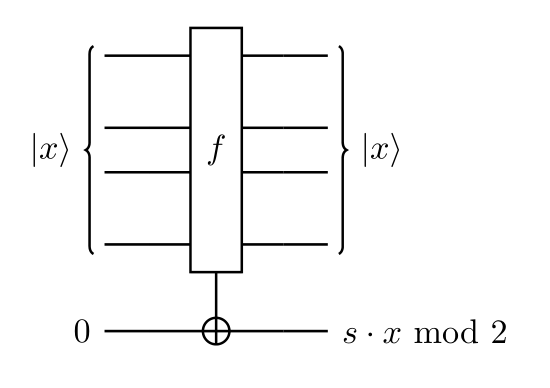

$f:\{0, 1\}^n \rightarrow \{0, 1\}$ where 
$f(x) = x\cdot a~(mod2)$ with $s \in \{0, 1\}^n$

그림의 f는 오라클을 나타내며 s는 우리가 찾아야 할 secret code입니다.

다음은 4비트의 secret code에 대한 BV 회로 입니다.

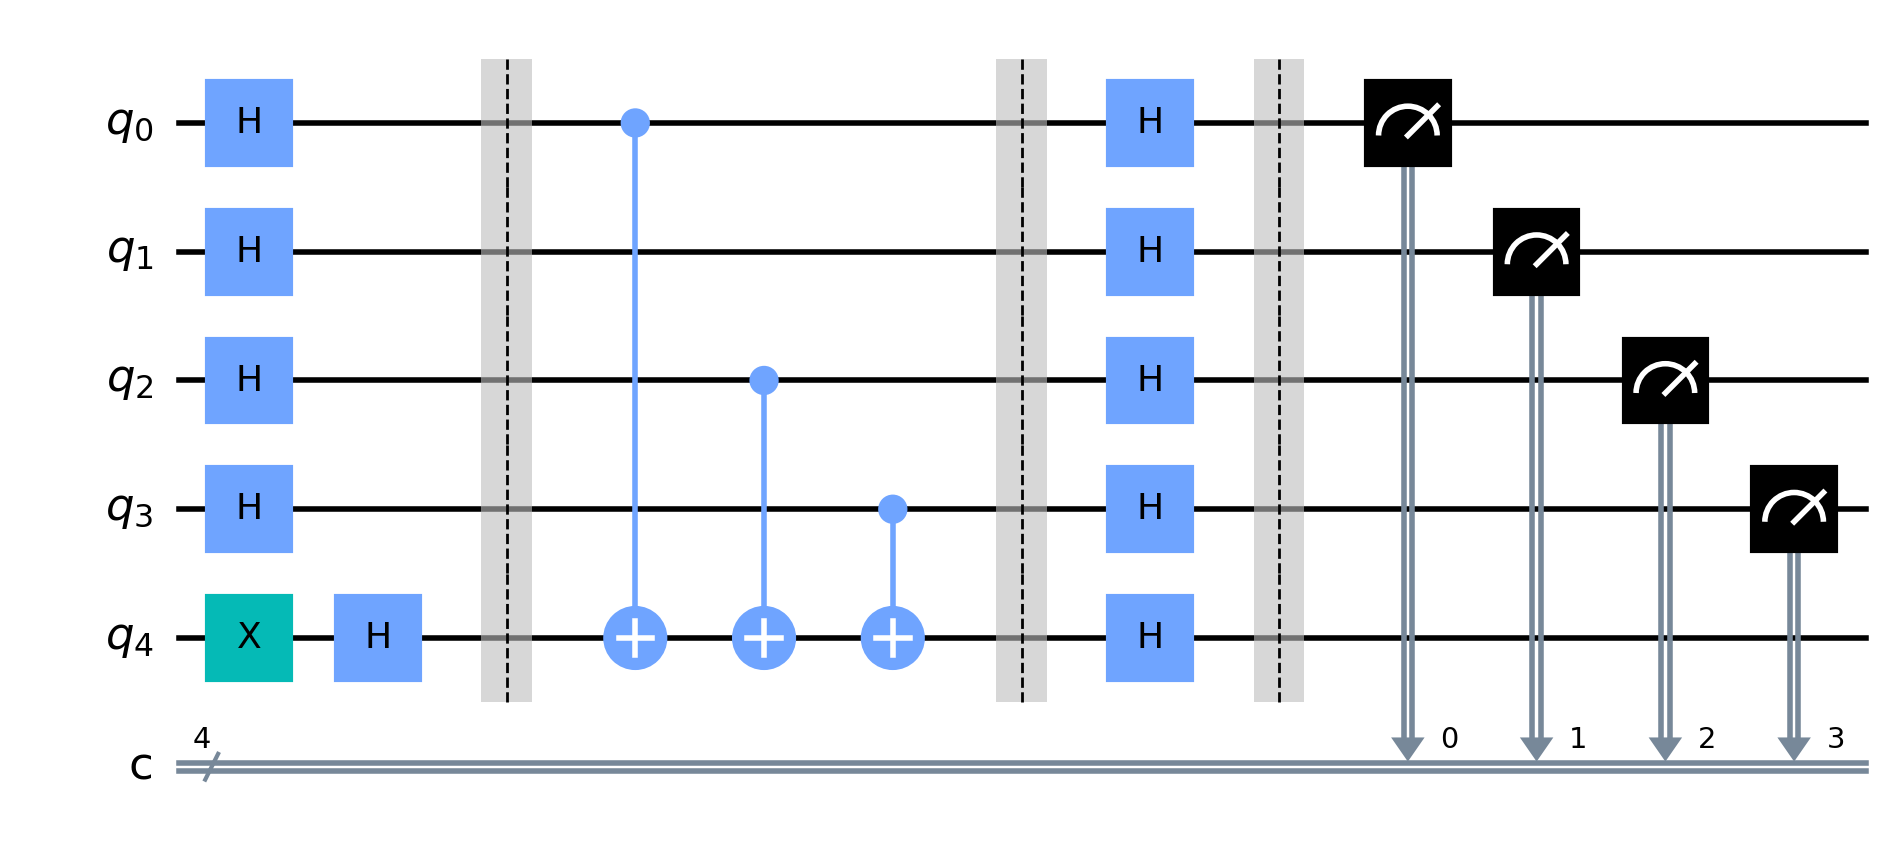

In [3]:
a = '1101'
nq = len(a)+1

bv = QuantumCircuit(nq, nq-1)
bv.x(nq-1)
bv.h(range(nq))
bv.barrier()
bv.cx([0, 2, 3], nq-1)
bv.barrier()
bv.h(range(nq))
bv.barrier()
bv.measure(range(nq-1), range(nq-1))

bv.draw('mpl')

### Ideal Simulation -  AerSimulator 
이 회로를 Aer의 시뮬레이터를 사용해 실행시켜 보도록 하겠습니다.

`qiskit_aer`는 Qiskit의 시뮬레이션 패키지로, 다음과 같은 시뮬레이터 들을 보유하고 있습니다
- [AerSimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.AerSimulator.html#qiskit_aer.AerSimulator)
- [QasmSimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.QasmSimulator.html#qiskit_aer.QasmSimulator)
- [StatevectorSimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.StatevectorSimulator.html#qiskit_aer.StatevectorSimulator)
- [UnitarySimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.UnitarySimulator.html#qiskit_aer.UnitarySimulator)

이 중 `AerSimulator`는 회로를 실행하고 측정된 값의 count를 반환합니다. 노이즈가 없는 이상적인 시뮬레이션을 하며 실행의 기본값은 `shots=1024`로 회로를 1024번 실행하도록 하고 있습니다. 

AerSimulator를 사용하기 위해서는 `backend`에 AerSimulator를 할당 한 후, `backend.run` 명령어에 회로를 넣어서 실행합니다.

다음과 같이 실습해 보고 회로의 결과를 그려봅시다. 

In [4]:
backend = AerSimulator()

In [5]:
counts_bv = backend.run(bv).result().get_counts()

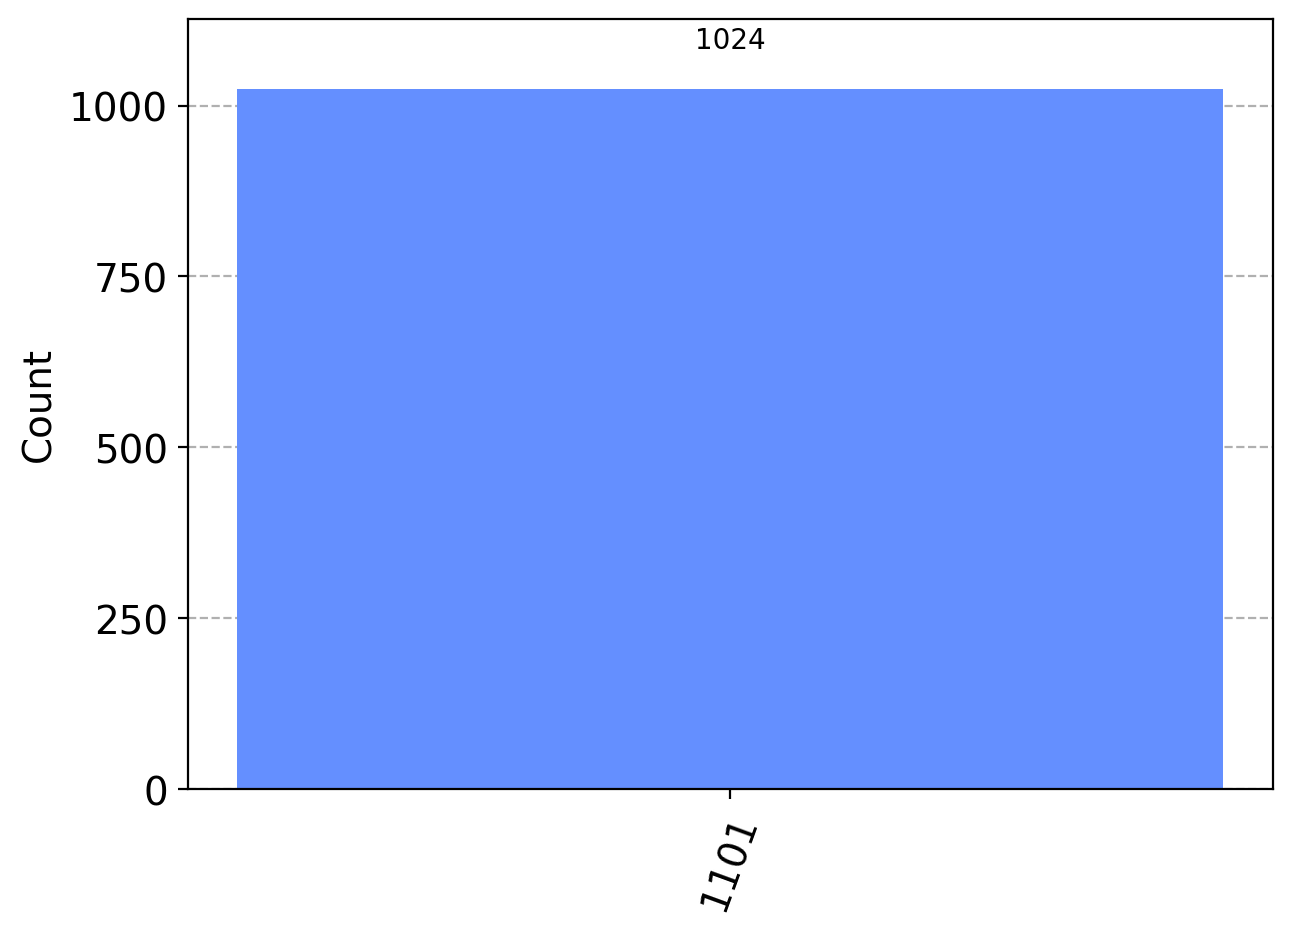

In [6]:
plot_histogram(counts_bv)

더 많은 shot수를 사용하고 싶다면 다음과 같이 설정합니다.

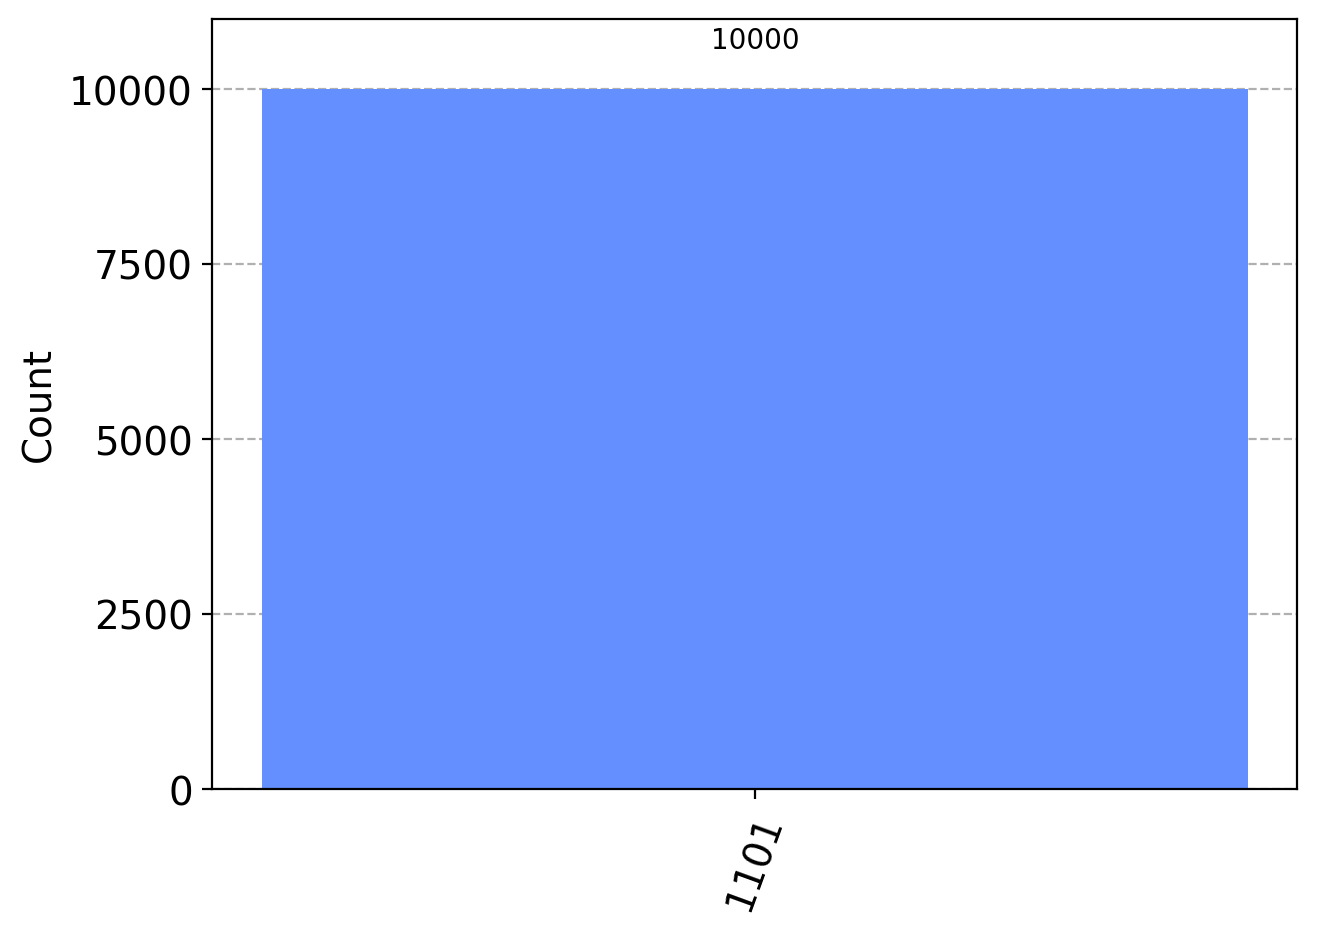

In [7]:
counts_bv = backend.run(bv, shots=10000).result().get_counts()
plot_histogram(counts_bv)

비슷한 용도이지만 측정되는 상태가 여러개일 경우 측정되는 count가 아닌 확률을 보여주는 다음과 같은 함수도 있습니다./

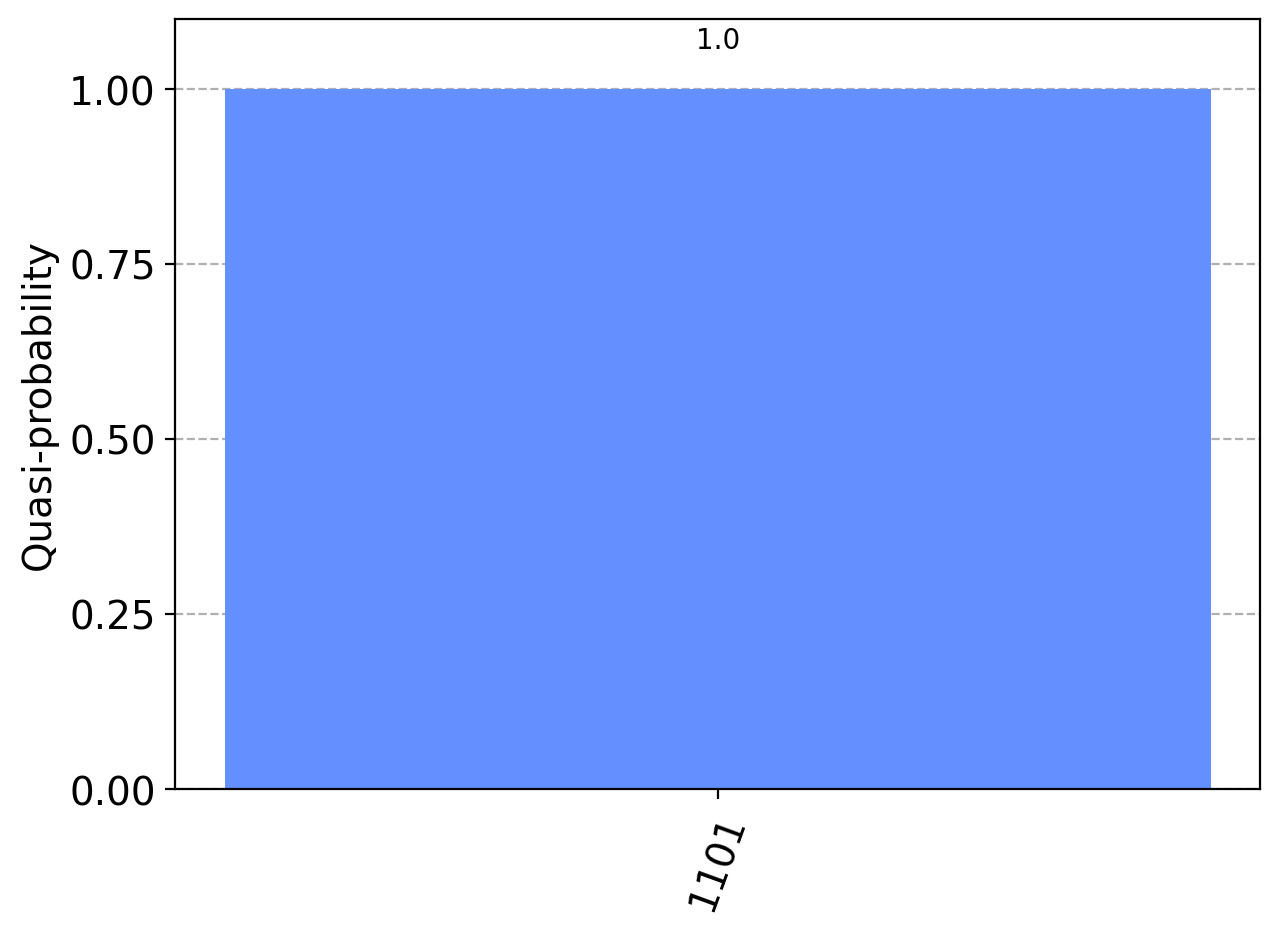

In [8]:
plot_distribution(counts_bv)

## Executing Quantum Circuit on IBM Quantum Systems

이제 이 회로를 실제 양자 백엔드에 실행해 보도록 합시다. local 환경에서 처음 cloud 의 백엔드를 억세스 할 경우, token을 설정해야 할 수 있습니다. 주석 처리된 코드를 사용해보세요. 기존에 저장된 토큰이 있을 경우 에러가 발생합니다. 아래의 예와 같이 overwrite=True 를 설정하면 에러를 방지할 수 있습니다.

실습을 위해 저도 저의 서울대 계정을 사용해서 같은 백엔드 수준을 유지하도록 하겠습니다.


In [9]:
#IBMProvider.save_account('YOUR_TOKEN', overwrite=True)

prov = IBMProvider()
prov.backends()

[<IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibm_auckland')>,
 <IBMBackend('ibm_washington')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibm_geneva')>,
 <IBMBackend('ibm_oslo')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_sherbrooke')>]

In [25]:
#choose auckland for BV run
backend = prov.get_backend('ibm_hanoi')

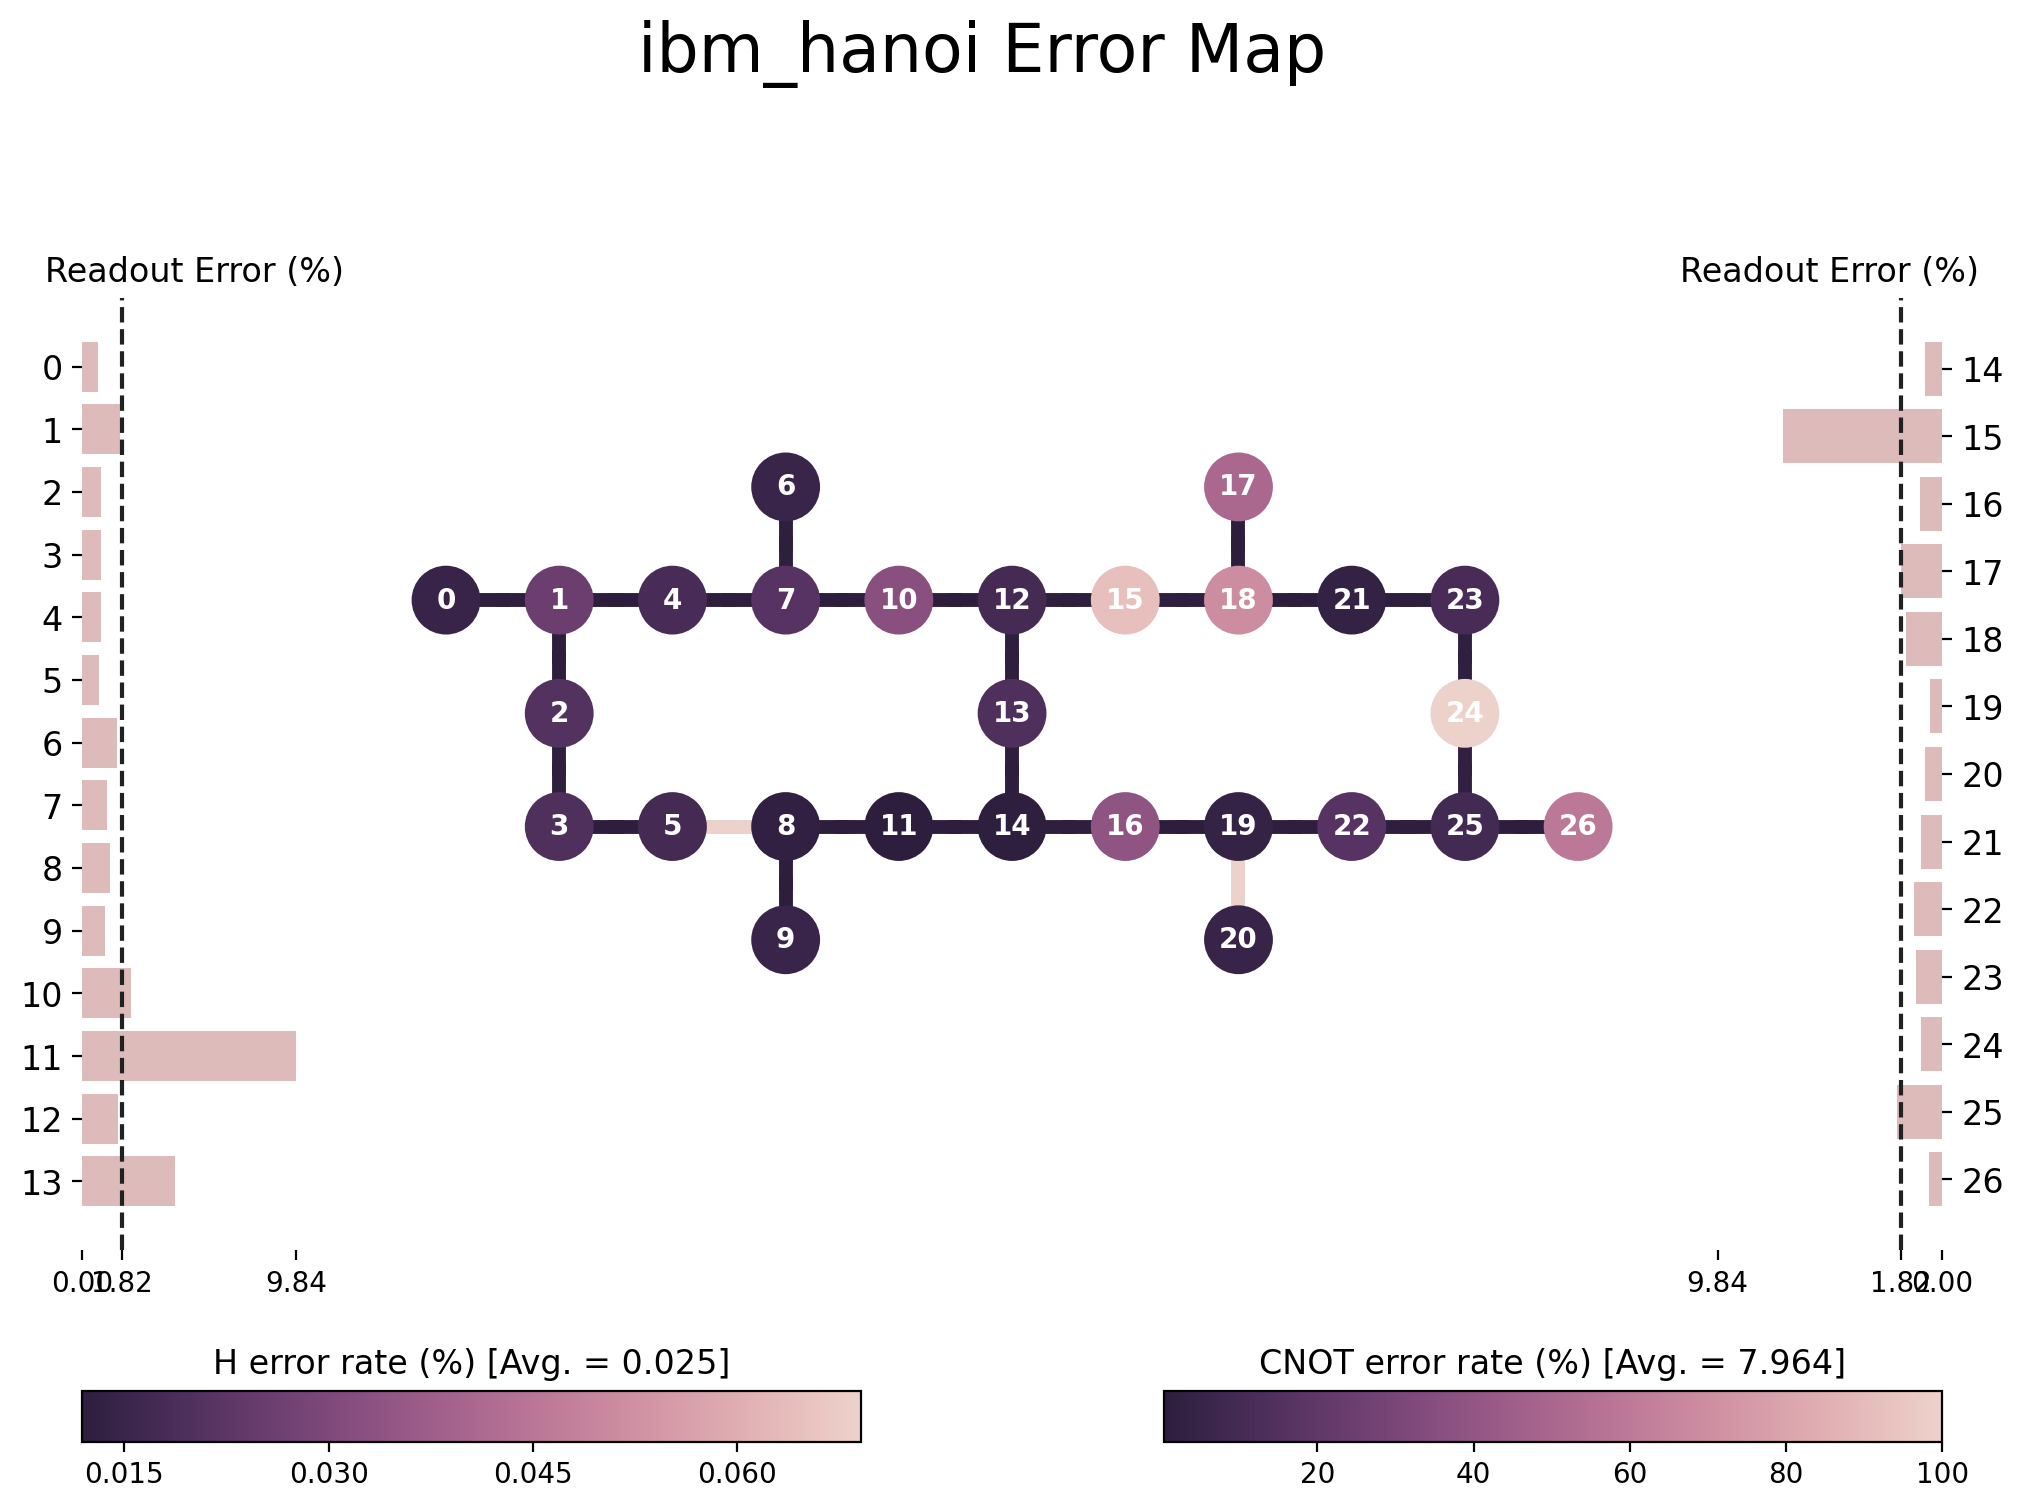

In [26]:
plot_error_map(backend)

양자 회로를 실제 백엔드에 실행하기 위해서는 transpile이 필요합니다. transpile은 1)양자 백엔드가 사용하는 basic gate로 회로를 변환하고, 2)노이즈를 줄이기 위해 몇가지 최적화 기술을 적용하는 등의 과정을 의미합니다. 

몇가지 transpiler의 옵션을 테스트 해보고 실습을 이어가 봅시다.

### play with [transpiler](https://qiskit.org/documentation/apidoc/transpiler.html) 

간단하게 Transpiler의 optimizatio level이 회로에 어떤 영향을 미치는지 확인해 봅시다.

In [27]:
tqc_bad = transpile(bv, backend, optimization_level=0)
tqc_good = transpile(bv, backend, optimization_level=3)

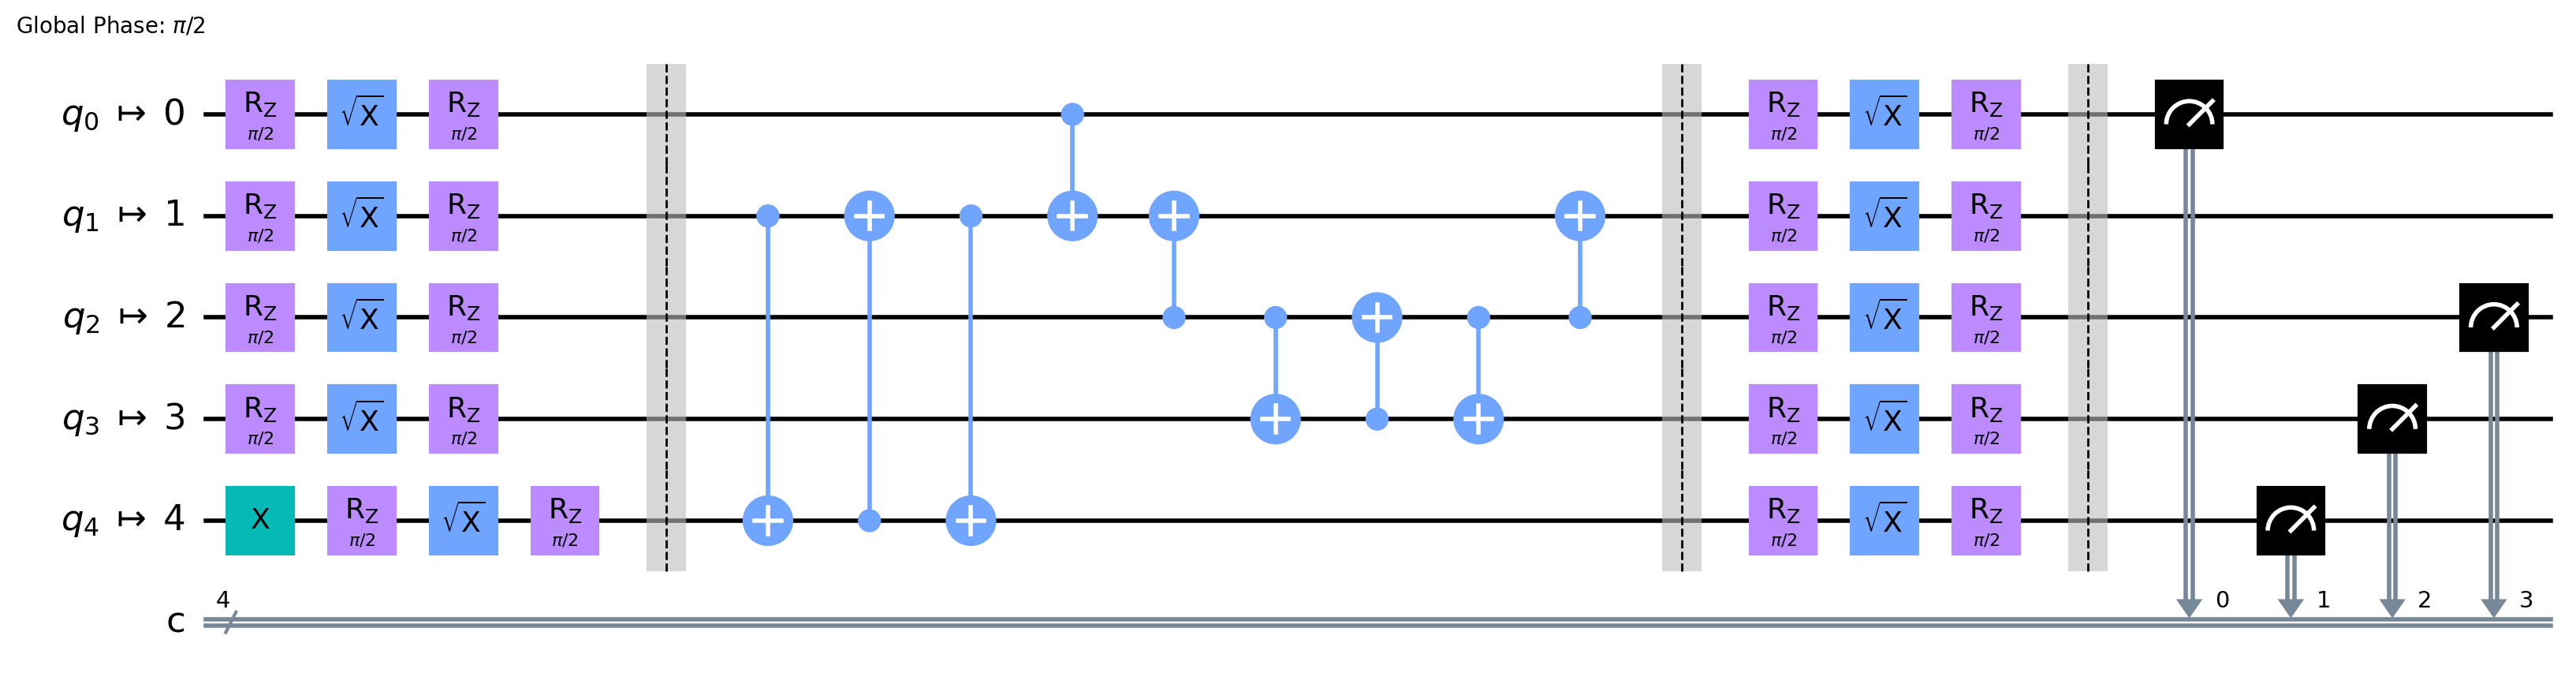

In [28]:
tqc_bad.draw('mpl', idle_wires=False)

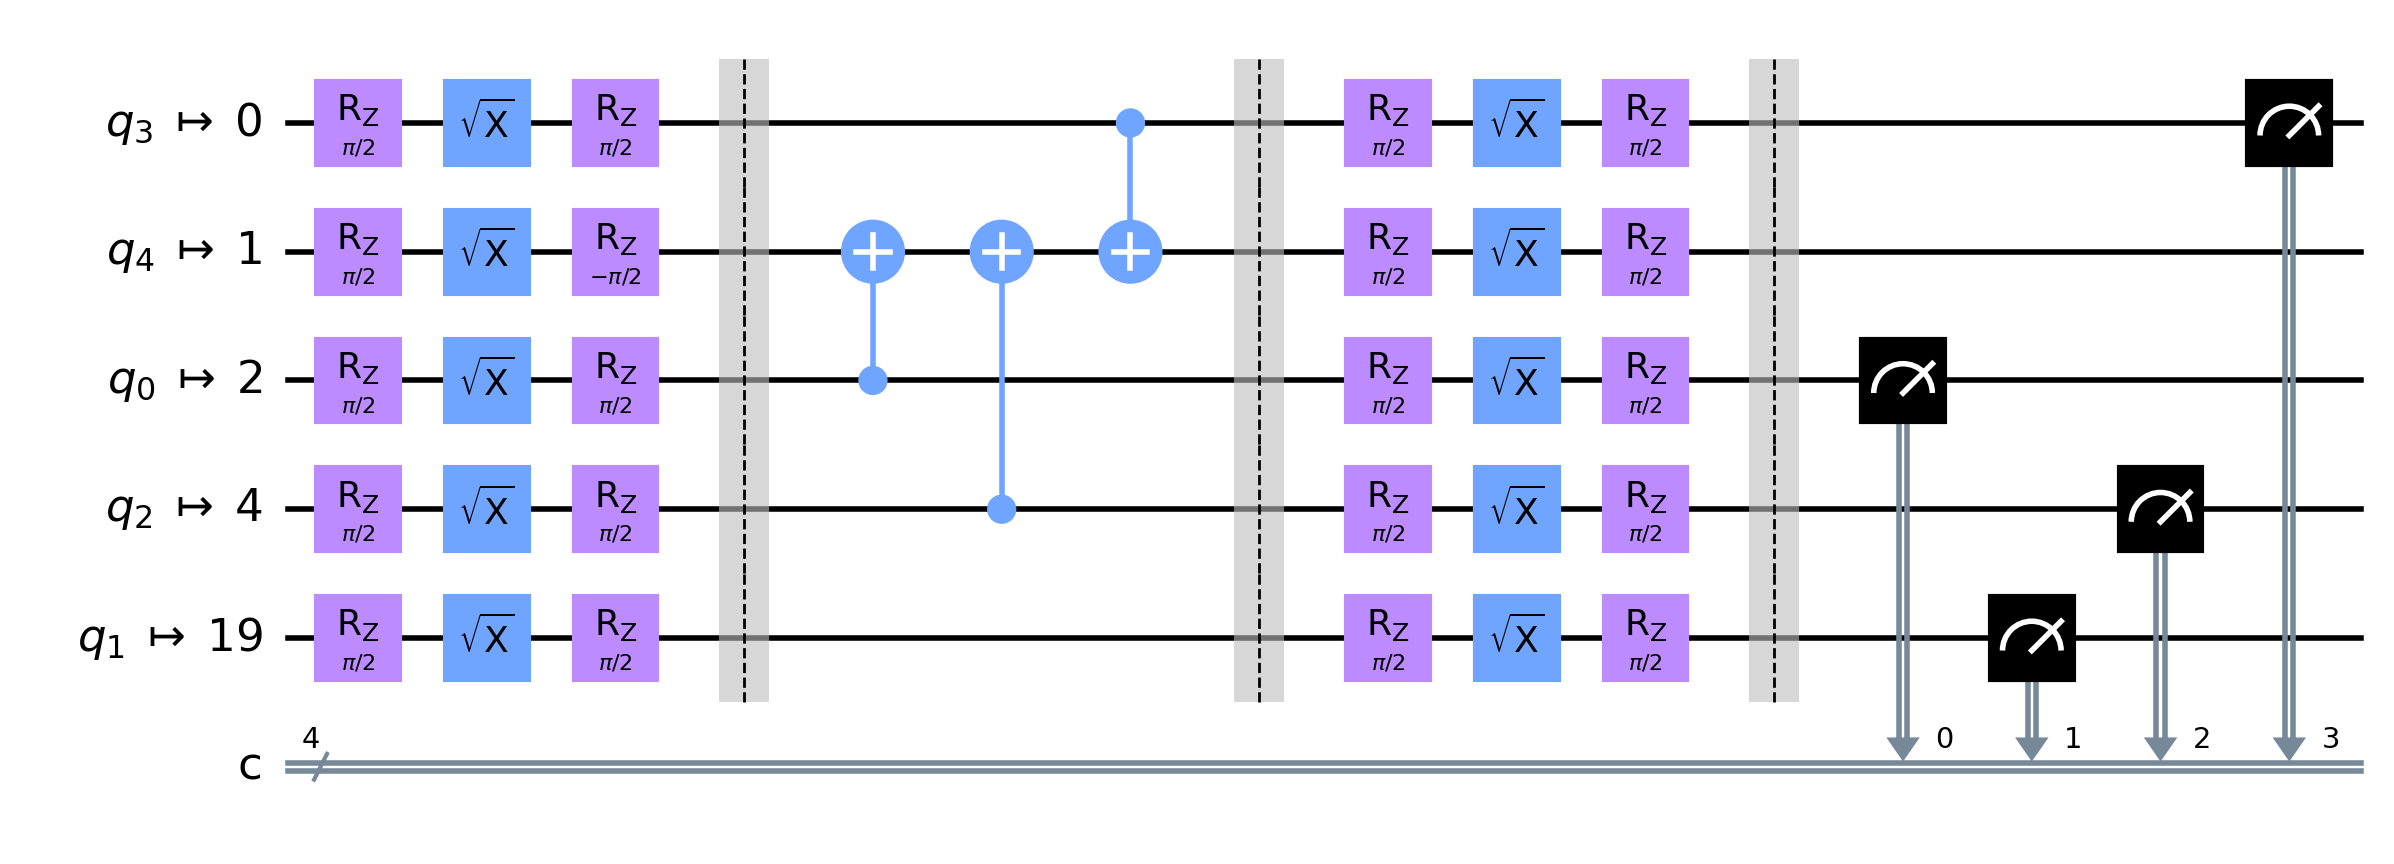

In [29]:
tqc_good.draw('mpl', idle_wires=False)

이 두가지 회로는 노이즈 시뮬레이터나 실제 백엔드에 실행했을때 성능이 어떻게 차이가 날까요? Fake Backend를 사용해서 간단하게 비교해 봅시다.

In [30]:
from qiskit.providers.fake_provider import FakeHanoi
fakebackend = FakeHanoi()

bad_counts = fakebackend.run(tqc_bad, shots=10000).result().get_counts()
good_counts = fakebackend.run(tqc_good, shots=10000).result().get_counts()

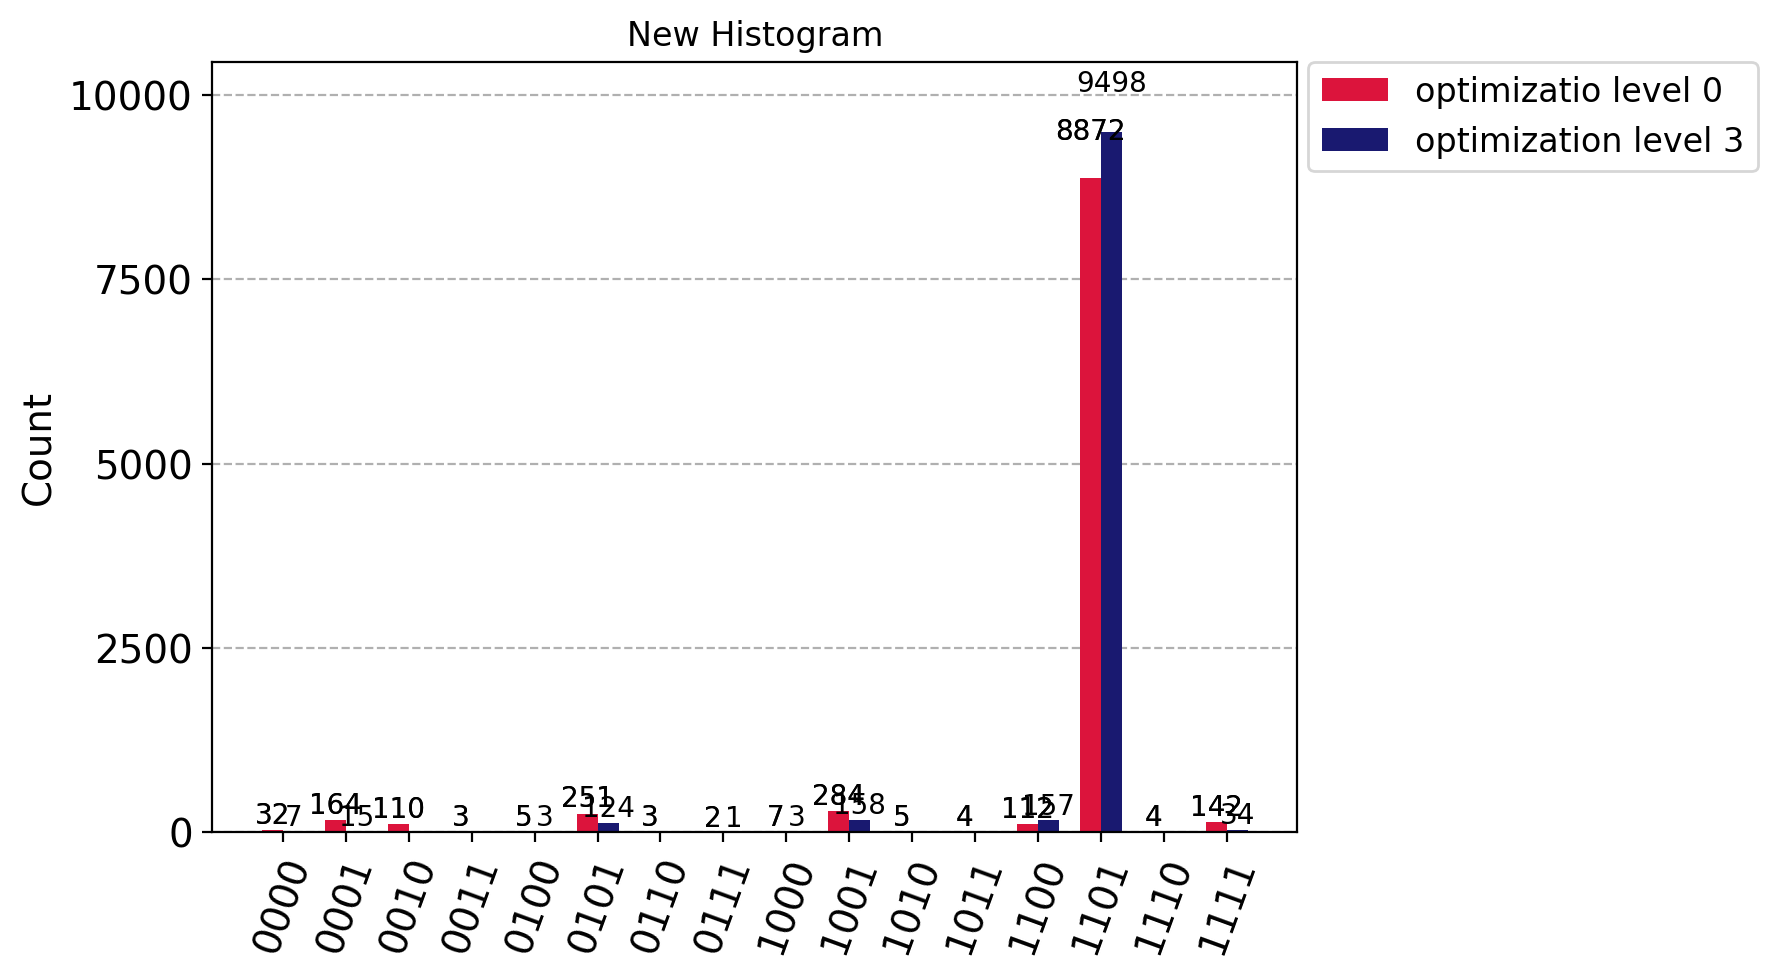

In [31]:
legend = ['optimizatio level 0', 'optimization level 3']

plot_histogram([bad_counts, good_counts], legend=legend, color=['crimson','midnightblue'],
                title="New Histogram")


회로를 그리는 몇가지 방법과 transpile 전후의 회로를 다음에서 비교해 볼수있습니다.

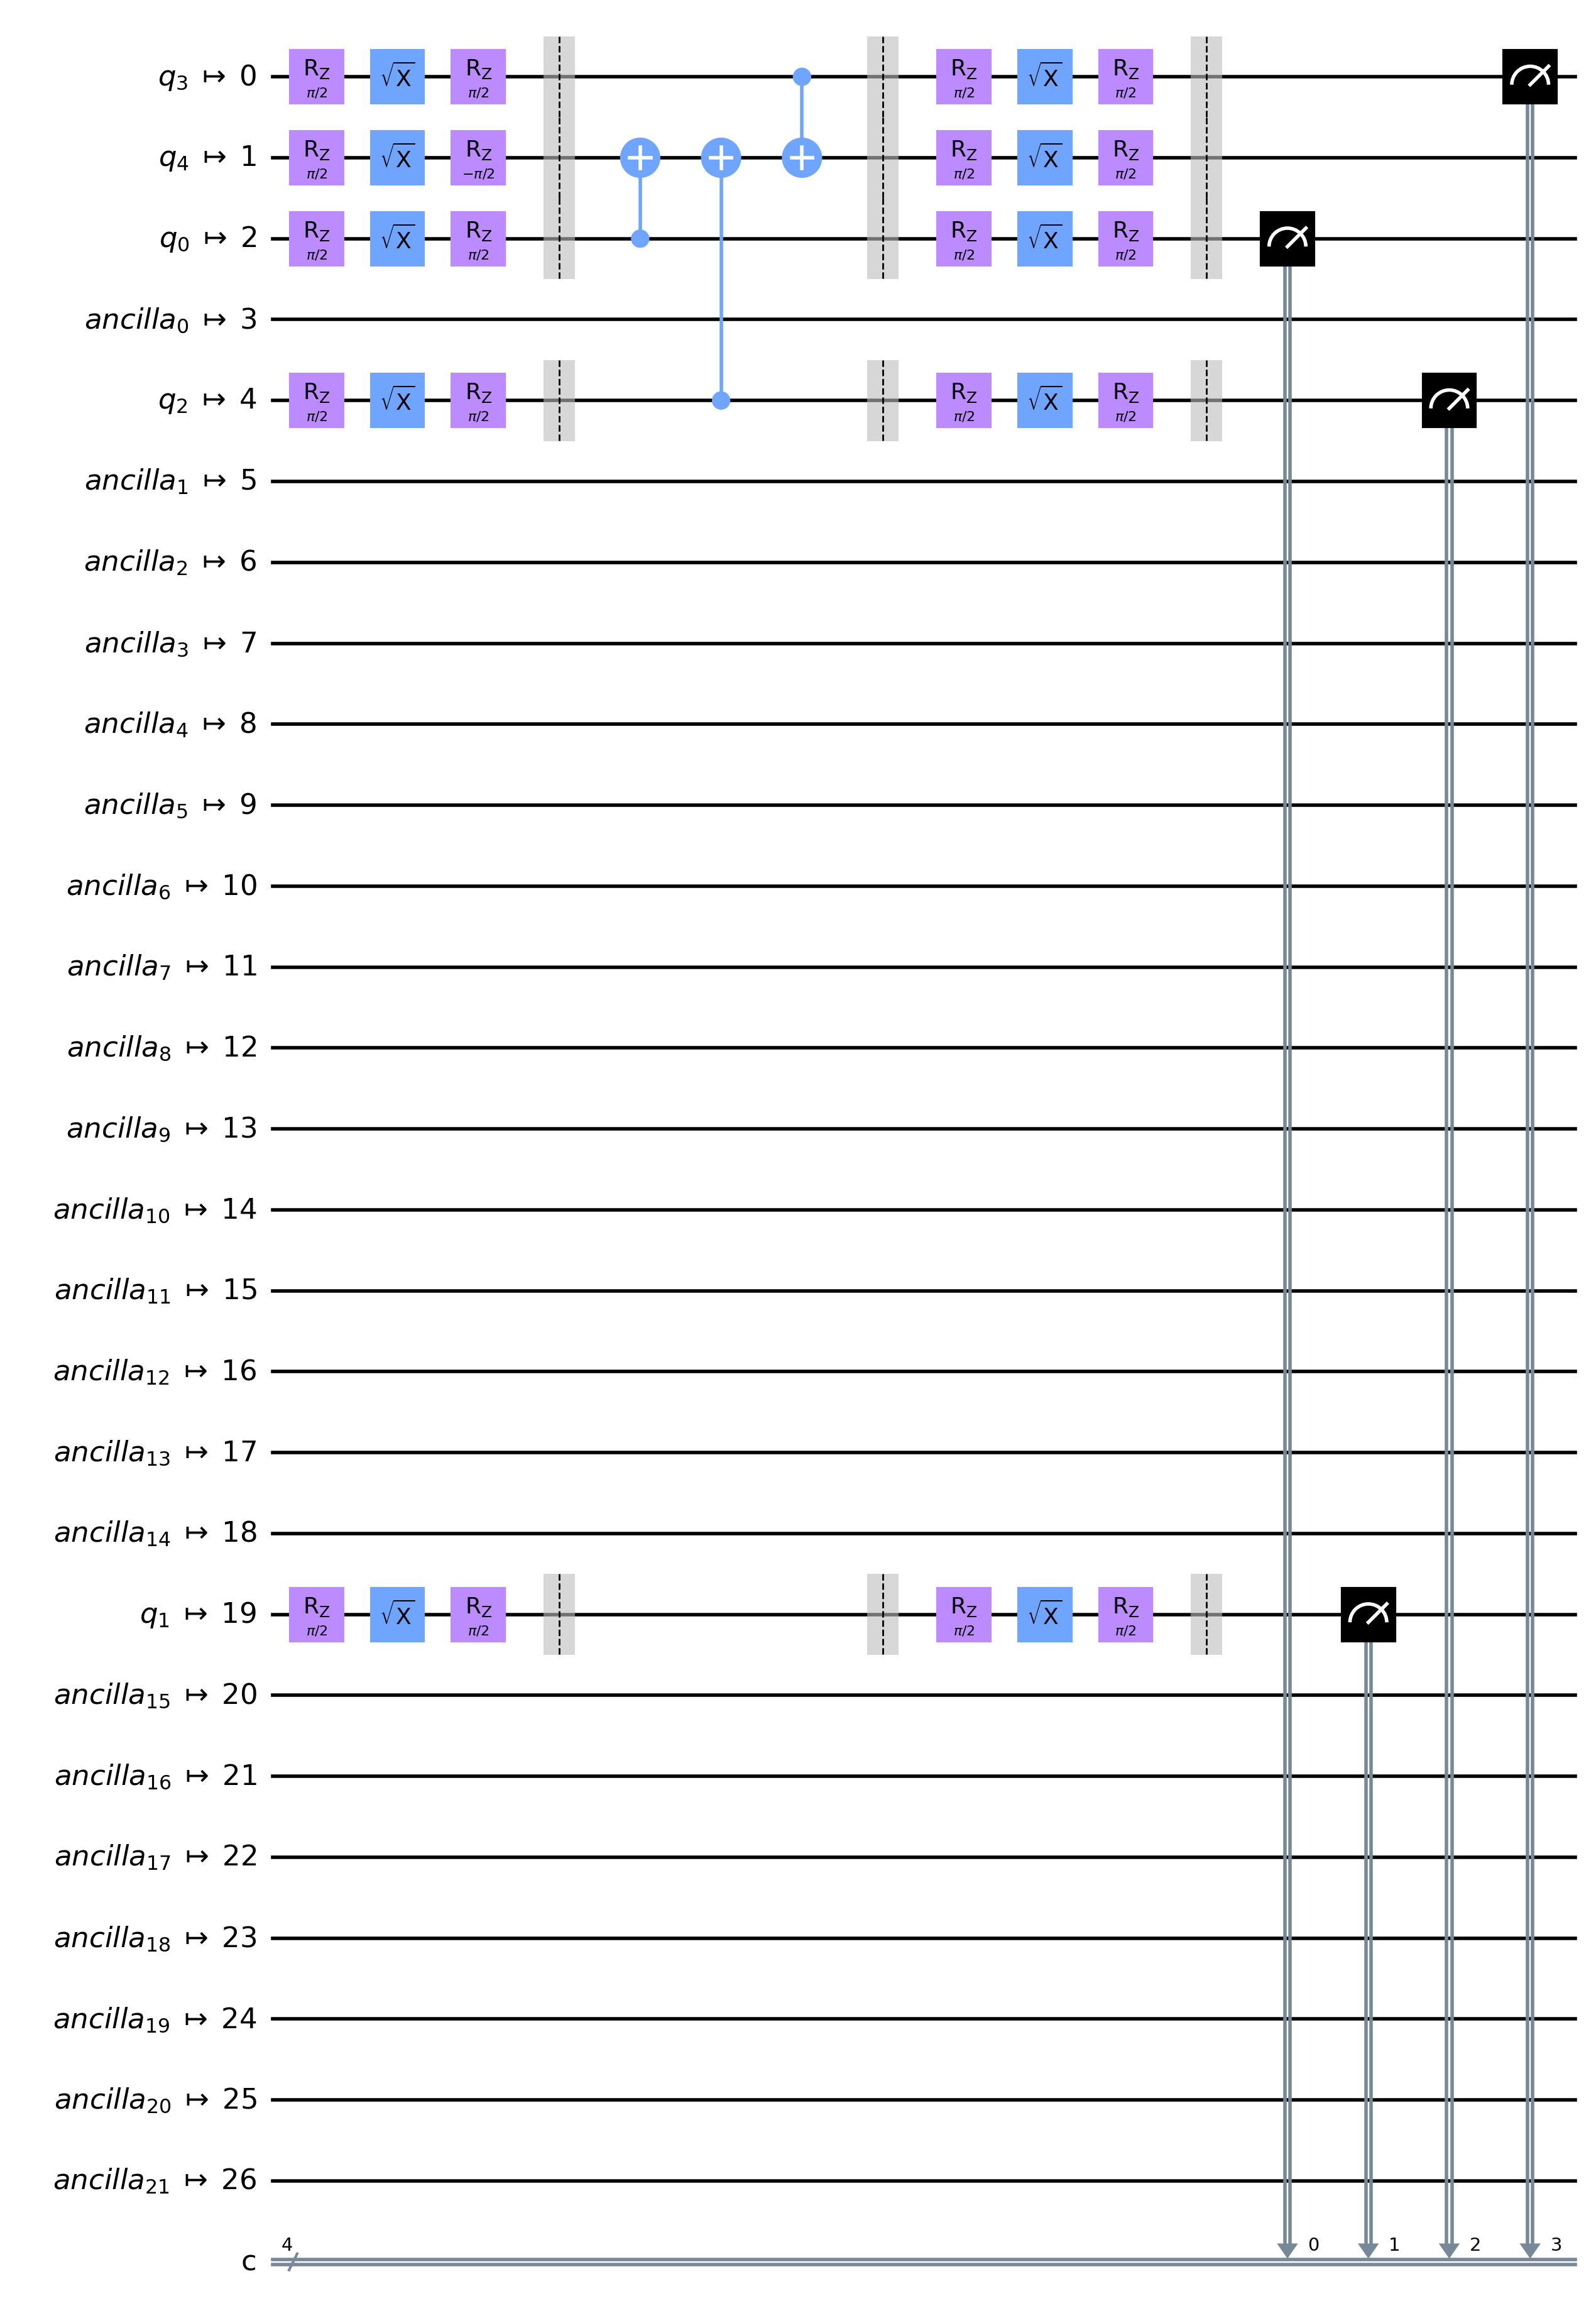

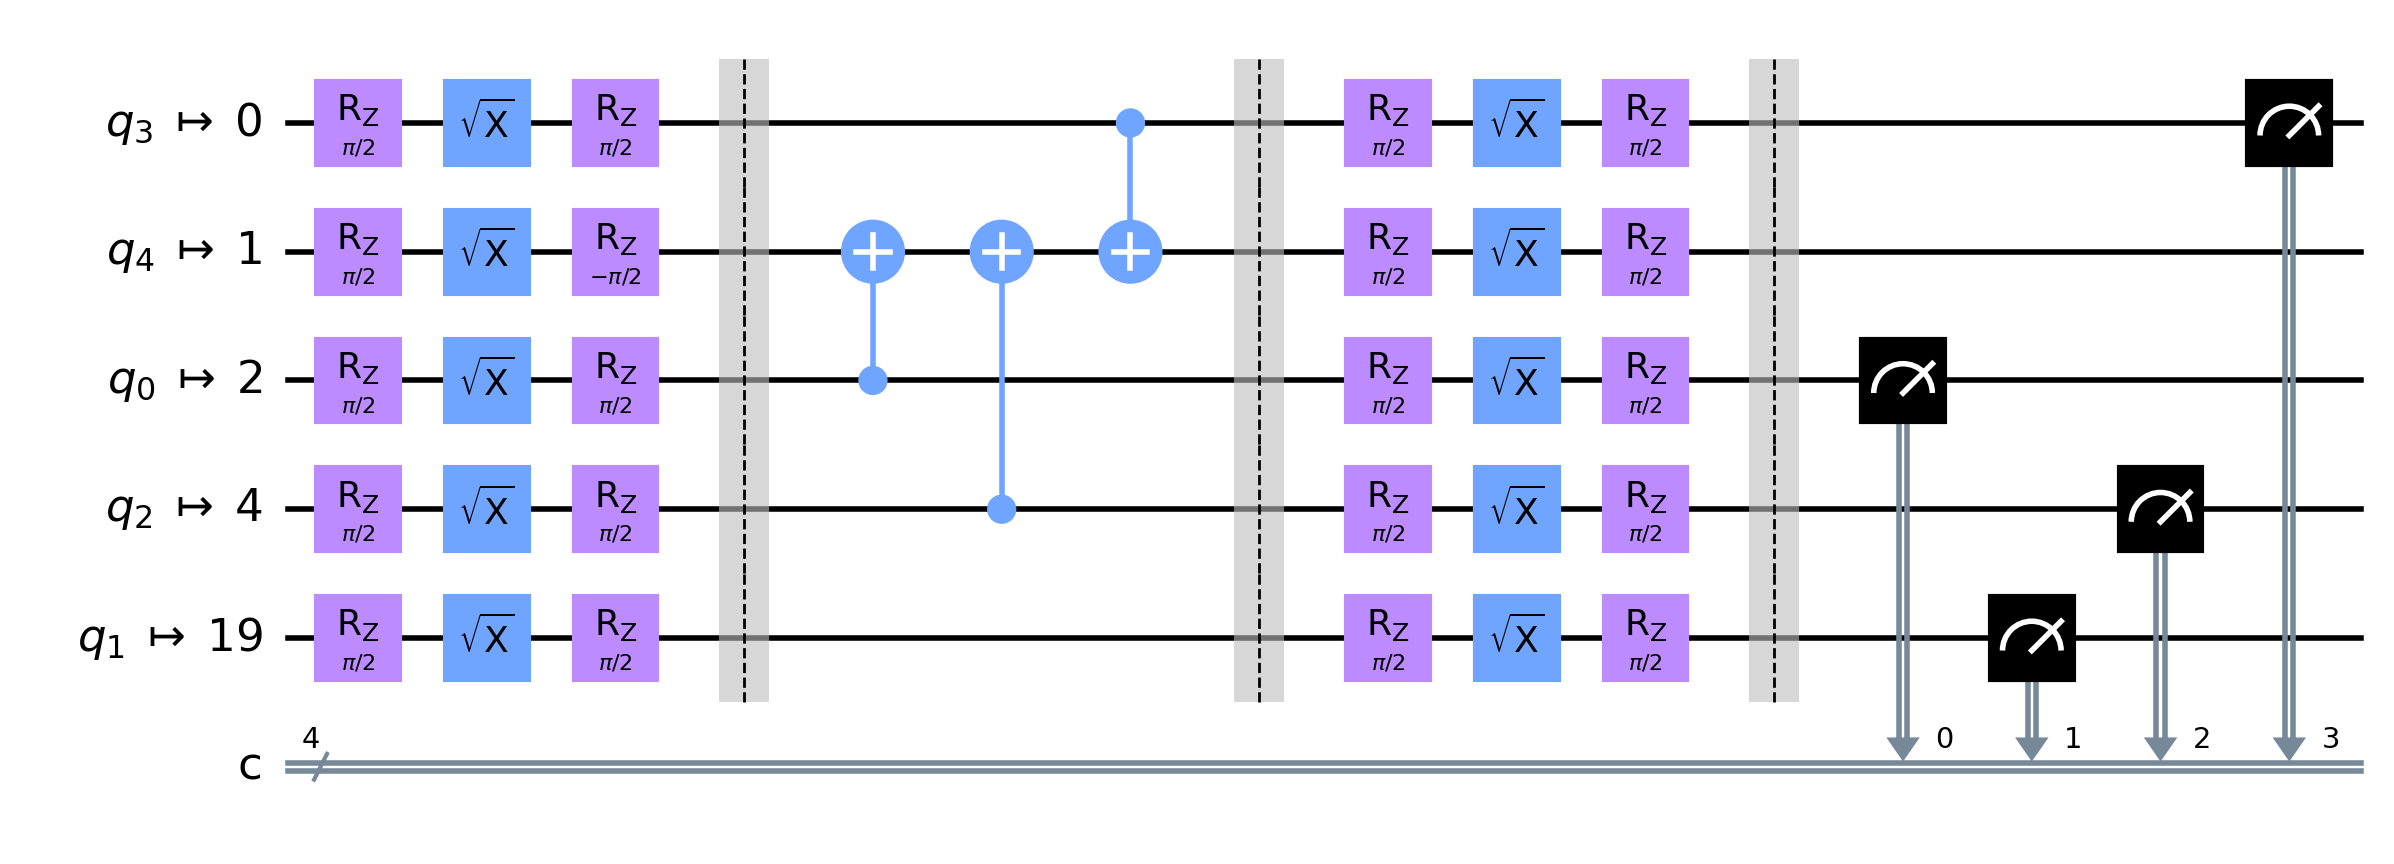

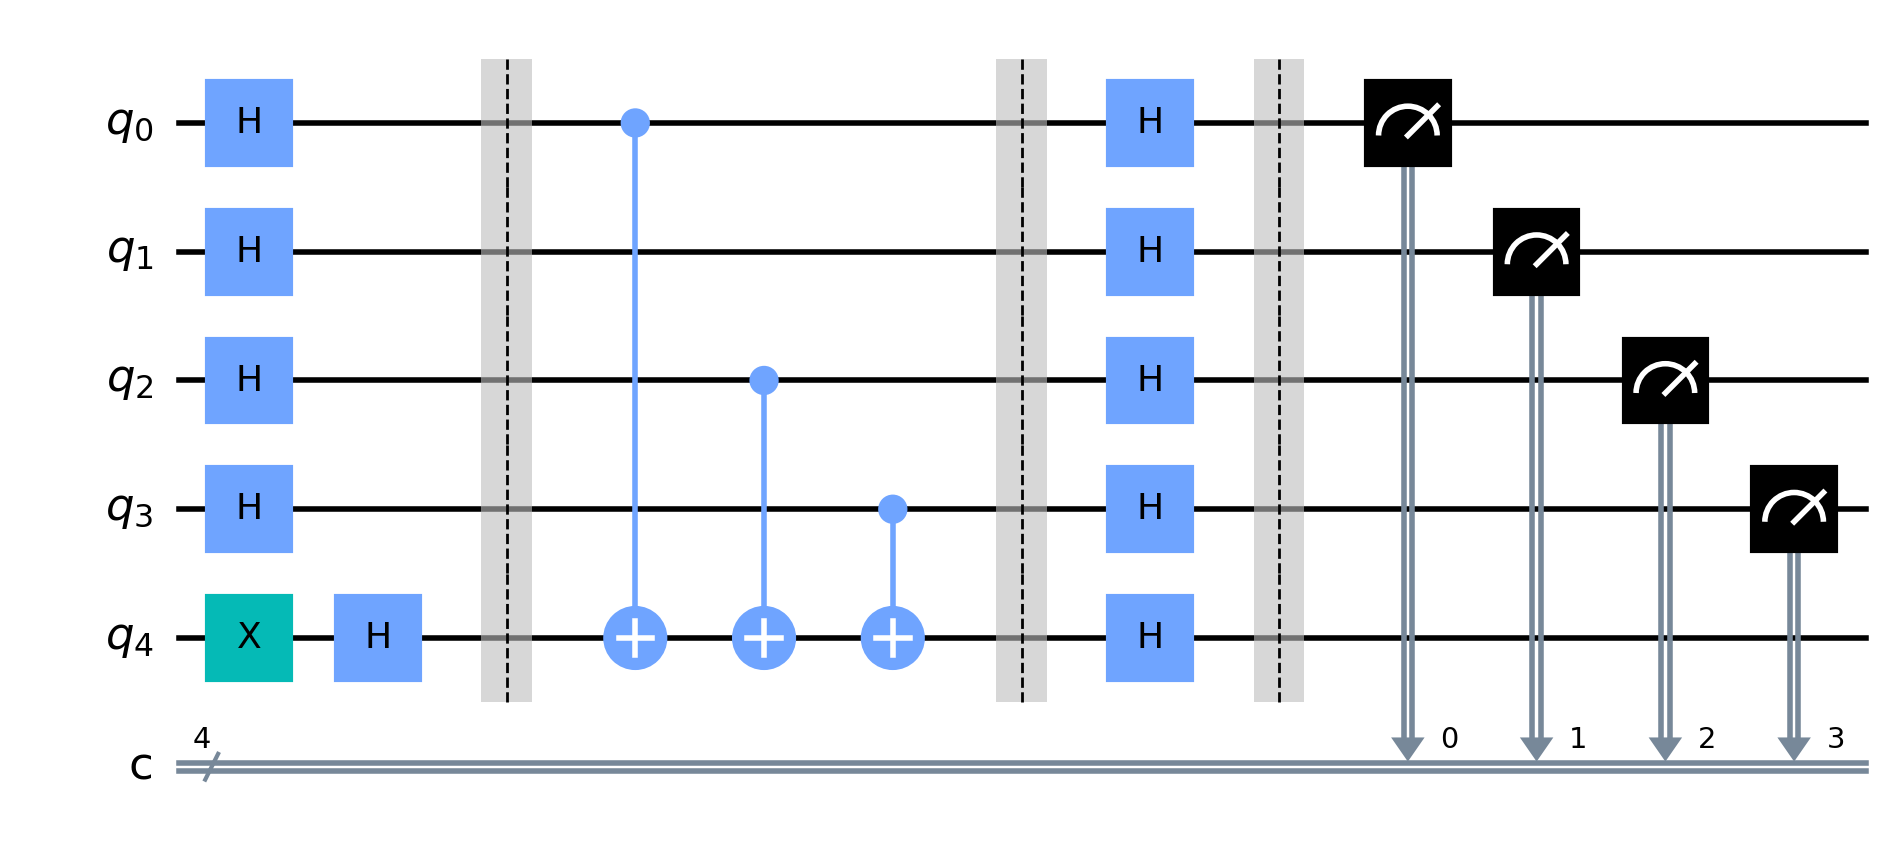

In [32]:
bv_trans = transpile(bv, backend)
display(bv_trans.draw('mpl'))
display(bv_trans.draw('mpl', idle_wires=False))
display(bv.draw('mpl'))

In [33]:
conf = backend.configuration()

#job0 = backend.run(bv_trans, shots=conf.max_shots) #default num_shots = 4000
#print(job0.job_id())

In [13]:
from qiskit.tools.monitor import job_monitor
job0 = prov.retrieve_job('ch3f5d97o5gvn6ongg4g')
job_monitor(job0)

Job Status: job has successfully run


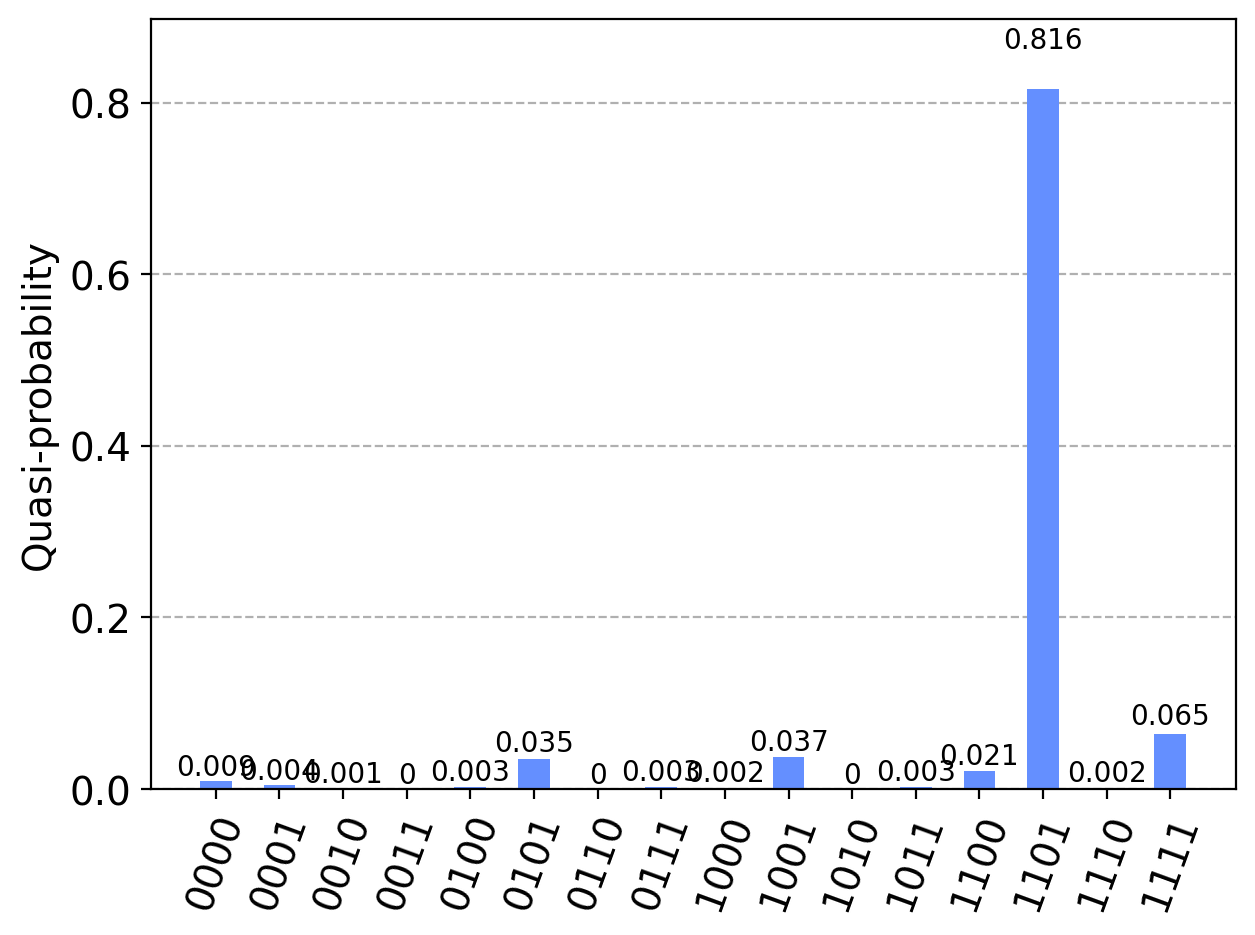

In [34]:
job0 = prov.retrieve_job('ch3f5d97o5gvn6ongg4g')
counts_bv = job0.result().get_counts()
plot_distribution(counts_bv)

이후에 사용하기 위해 secret code가 모두 1로 구성된 N 큐비트 BV 회로를 만드는 함수를 작성해 둡시다.

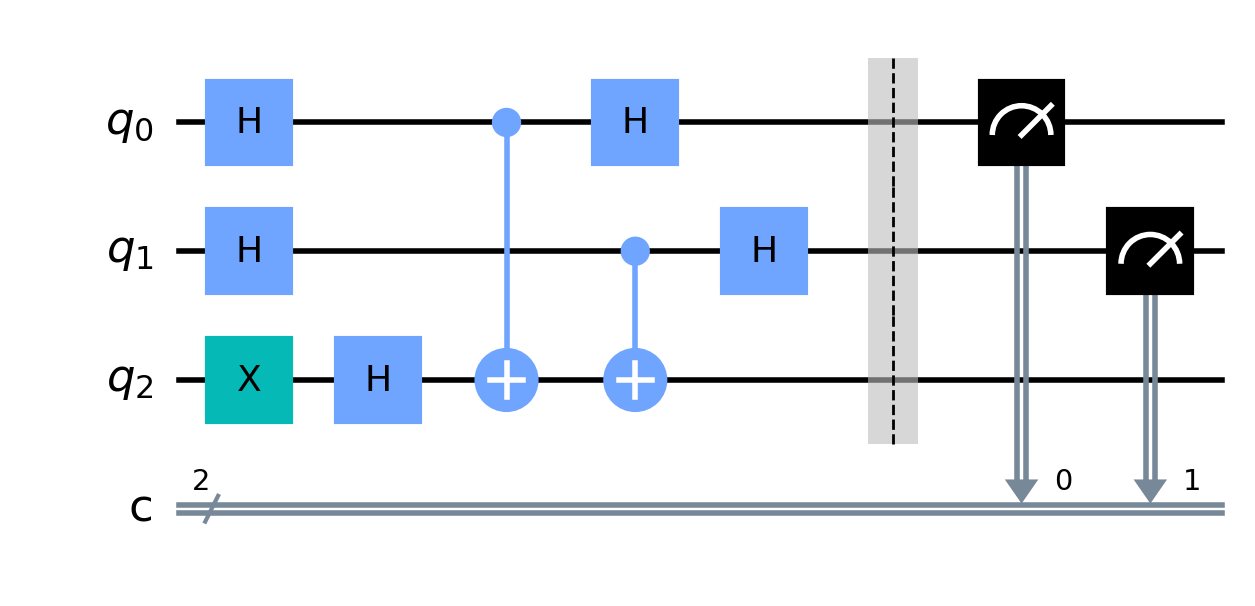

In [36]:
#define useful function

def bv_ones_circs(N):
    """Create a Bernstein-Vazirani circuit with all-ones oracle of width N
    """
    qc = QuantumCircuit(N, N-1)
    qc.x(N-1)
    qc.h(range(N))
    qc.cx(range(N-1), N-1)
    qc.h(range(N-1))
    qc.barrier()
    qc.measure(range(N-1), range(N-1))
    return qc

N = 3
qc = bv_ones_circs(N)
qc.draw('mpl')

지금까지 4비트 크기의 secret 문자열을 지닌 BV회로를 만들고 이상적인 경우의 시뮬레이터와 실제 백엔드에서 실행해 보았습니다. 

만약 더 긴 secret 문자열을 지닌 회로를 만든다면, 그 결과는 어떻게 될까요? 우리의 Noisy한 백엔드는 어떤 결과를 보여줄까요. 결과를 눈으로 확인 하기 전 NISQ Era의 양자백엔드가 지닌 문제점으로 인한 한계를  살펴 봅시다. 

우선 더 긴 문자열을 처리하기 위해서는 더 많은 큐비트가 필요합니다, Heavy-hex 구조를 사용하고 있는 IBM Quantum의 양자 백엔드에서, 큐비트당 약 3개 이상의 CNOT 게이트가 필요한 모든 회로는 하드웨어에 실행하기 위해 재구성 되어야 하며 이를 위해서 추가적인 Swap 게이트가 사용됨을 의미합니다. 

이 추가적으로 사용되는 SWAP 게이트들은 실행 결과의 Fidelity를 급격히 떨어뜨립니다.

첫번째로, Aersimulator에 real backend의 특성을 입혀서 계산에 사용하여 눈으로 확인해 봅시다.

In [37]:
sim = AerSimulator.from_backend(backend)

secret code가 모두 1로 되어 잇는 2큐빗 부터 10큐빗 까지의 BV회로 리스트를 만들어 봅시다. 

In [38]:
MAX_BITS = 10
bv_circs = [bv_ones_circs(N) for N in range(2, MAX_BITS+1)]

가장 이상적인 결과를 얻기 위해 (당연한 결과가 나오겠지만!) AerSimulator를 사용해 봅시다.

In [39]:
backend_Aer = AerSimulator()

In [40]:
Aer_counts = backend_Aer.run(bv_circs, shots=10000).result().get_counts()

In [41]:
Aer_fidelities = [hellinger_fidelity(cnts, {'1'*(idx+1): 1}) for idx, cnts in enumerate(Aer_counts)]

Noisy simulator에 회로를 실행하기 위해 Transpile을 해봅니다. 이번엔 Transpile 옵션 중 pulse timing을 조절하는 옵션을 추가해보겠습니다. 이와 관련한 더 자세한 정보는 [이곳](https://qiskit.org/documentation/tutorials/circuits_advanced/07_pulse_scheduler.html#Scheduler-methods)에서 확인할 수 있습니다. 더 정확한 결과를 얻기 위해 timing 정보를 추가해 회로를 백엔드에 맞게 transpile 합니다.

In [42]:
trans_bv_circs = transpile(bv_circs, backend=backend, optimization_level=3, scheduling_method='alap')

In [43]:
sim_counts = sim.run(trans_bv_circs, shots=10000).result().get_counts()

In [44]:
sim_fidelities = [hellinger_fidelity(cnts, {'1'*(idx+1): 1}) for idx, cnts in enumerate(sim_counts)]

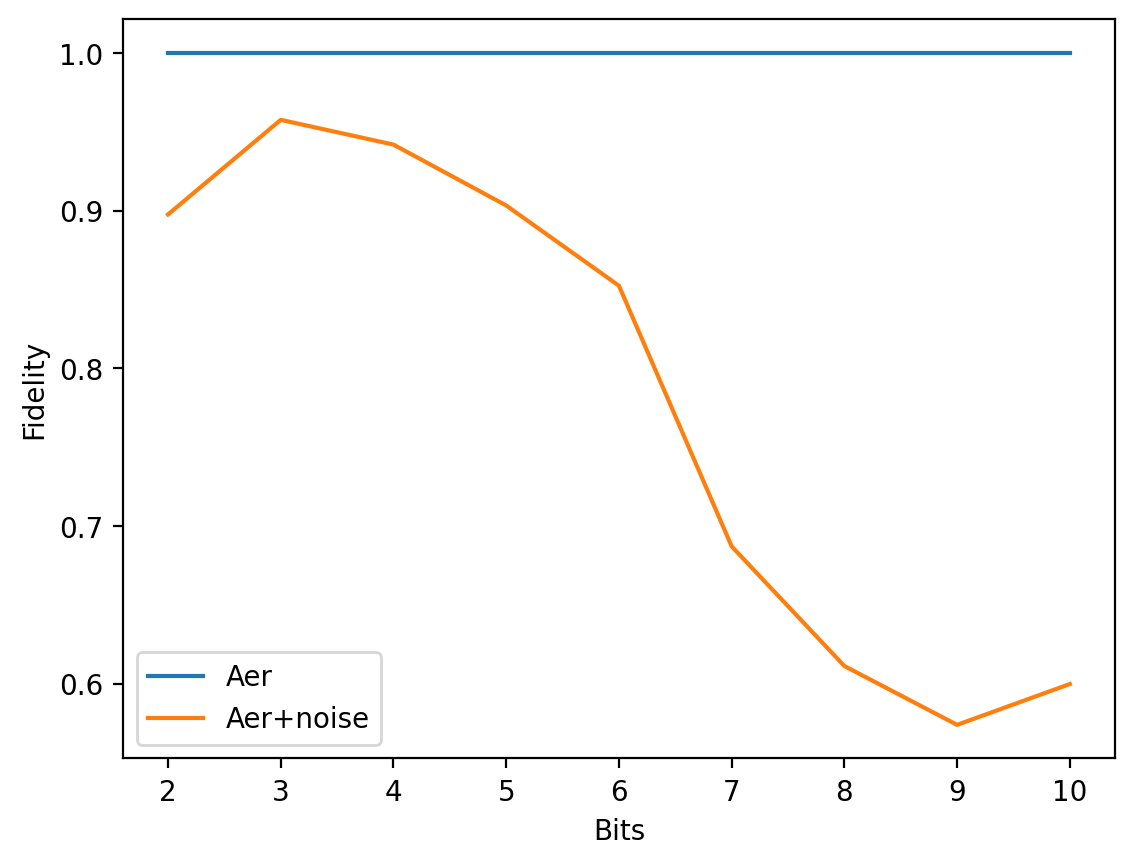

In [45]:
fig, ax = plt.subplots()
ax.plot(range(2, MAX_BITS+1), Aer_fidelities, label='Aer')
ax.plot(range(2, MAX_BITS+1), sim_fidelities, label='Aer+noise')
ax.set_xlabel('Bits')
ax.set_ylabel('Fidelity')
ax.legend();

In [67]:
#job = backend.run(trans_bv_circs, shots=10000)

In [68]:
#job.job_id()

'ch3f67ol1tcjfhlfdn10'

In [46]:
job0 = prov.retrieve_job('ch3e54accl2b15oi1t30')
#job_monitor(job0)
job0.status()

<JobStatus.DONE: 'job has successfully run'>

In [47]:
real_counts = job0.result().get_counts()
real_fidelities = [hellinger_fidelity(cnts, {'1'*(idx+1): 1}) for idx, cnts in enumerate(real_counts)]

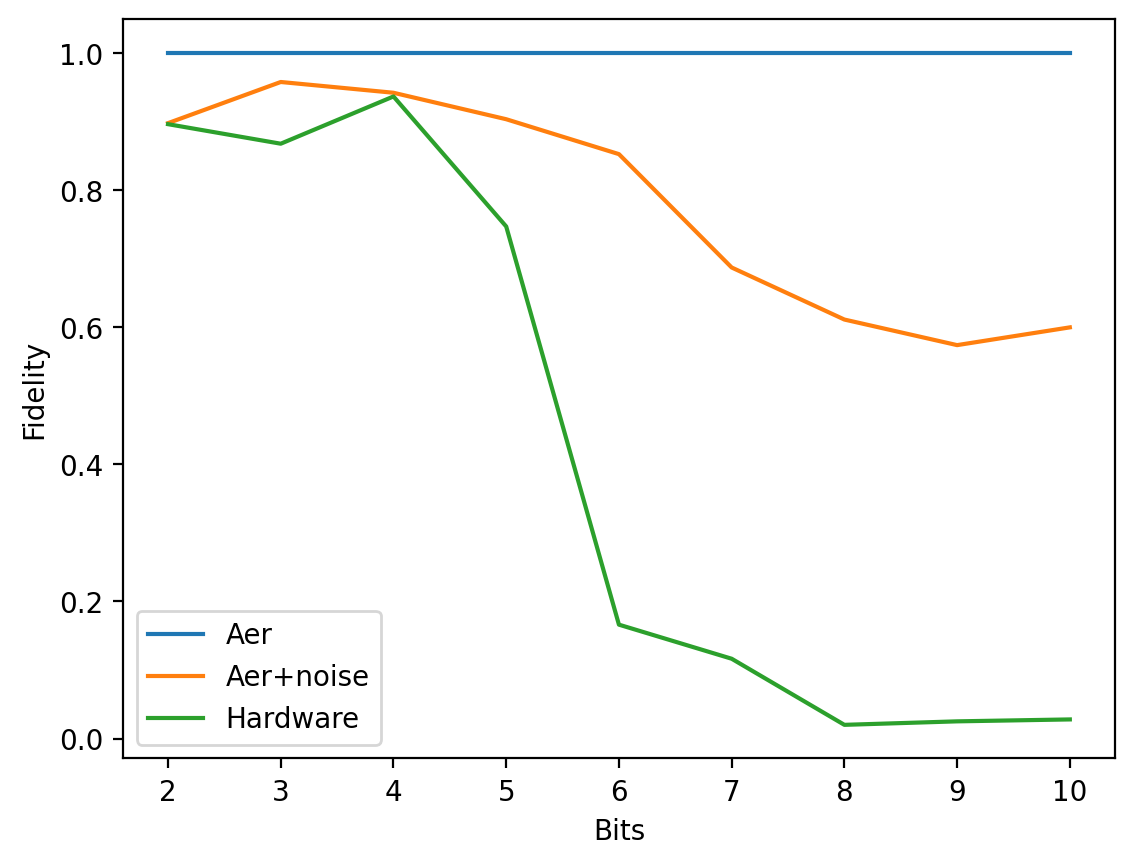

In [48]:
fig, ax = plt.subplots()
ax.plot(range(2, MAX_BITS+1), Aer_fidelities, label='Aer')
ax.plot(range(2, MAX_BITS+1), sim_fidelities, label='Aer+noise')
ax.plot(range(2, MAX_BITS+1), real_fidelities, label='Hardware')
ax.set_xlabel('Bits')
ax.set_ylabel('Fidelity')
ax.legend();

그림에서 알 수 있듯이 6비트이상의 크기의 회로에서는 회로의 충실도가 급격히 낮아짐을 알 수 있습니다. 이는 일반적으로 큐비트의 연결성와 관련하여 swap 게이트들이 회로를 실행할때 추가되는 것으로 인한것으로 이해해도 좋습니다. 큐비트의 relaxation과 depolarization을 고려하여 타이밍을 추가했음에도 결과가 이상적인 경우에 비해 좋지 않음도 알 수있습니다. 

바로 이러한 포인트에서 Qiskit-Dynamic가 필요합니다. 

## Improve Fideltity by Using Dynamic Circuit

### Dynamic Circuit Intro

Dynamic Circuit은 큐비트에 게이트 및 측정을 적용할 수 있을 뿐만 아니라 큐비트의 coherence 시간 내에 고전적인 계산 및 측정 결과에 조건부 연산을 적용할 수 있는 기능을 가진 양자 회로(또는 프로그램!)입니다. [동적 회로](https://medium.com/qiskit/a-new-openqasm-for-a-new-era-of-dynamic-circuits-87f031cac49)는 [IBM Quantum 하드웨어 로드맵](https://research.ibm.com/blog/ibm-quantum-roadmap-2025)의 중요한 구성 요소입니다.

Dynamic Circuit을 시작하는 첫걸음은 `reset` 명령어를 사용하는 것입니다. 이 명령어는 회로의 중간에서 큐비트를 $|0\rangle$ 상태로 초기화 합니다.

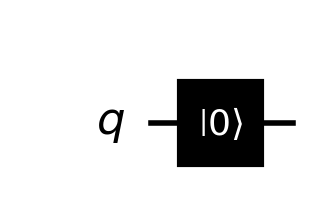

In [49]:
qc_reset = QuantumCircuit(1)
qc_reset.reset(0)
qc_reset.draw('mpl')

다음은 특정 조건이 만족될때 큐비트를 원하는 값으로 설정하는 `if_test`를 사용해 보는 것입니다.

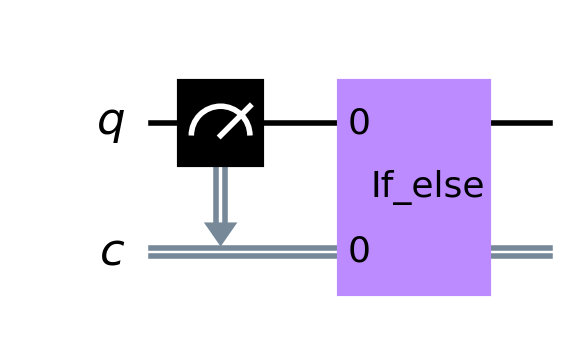

In [50]:
qc = QuantumCircuit(1, 1)
qc.measure(0, 0)

# If bit 0 is 1, perform an x-gate, else do nothing
with qc.if_test((0, True)):
    qc.x(0)

qc.draw('mpl')

### BV로 Dynamic Circuit 만들기

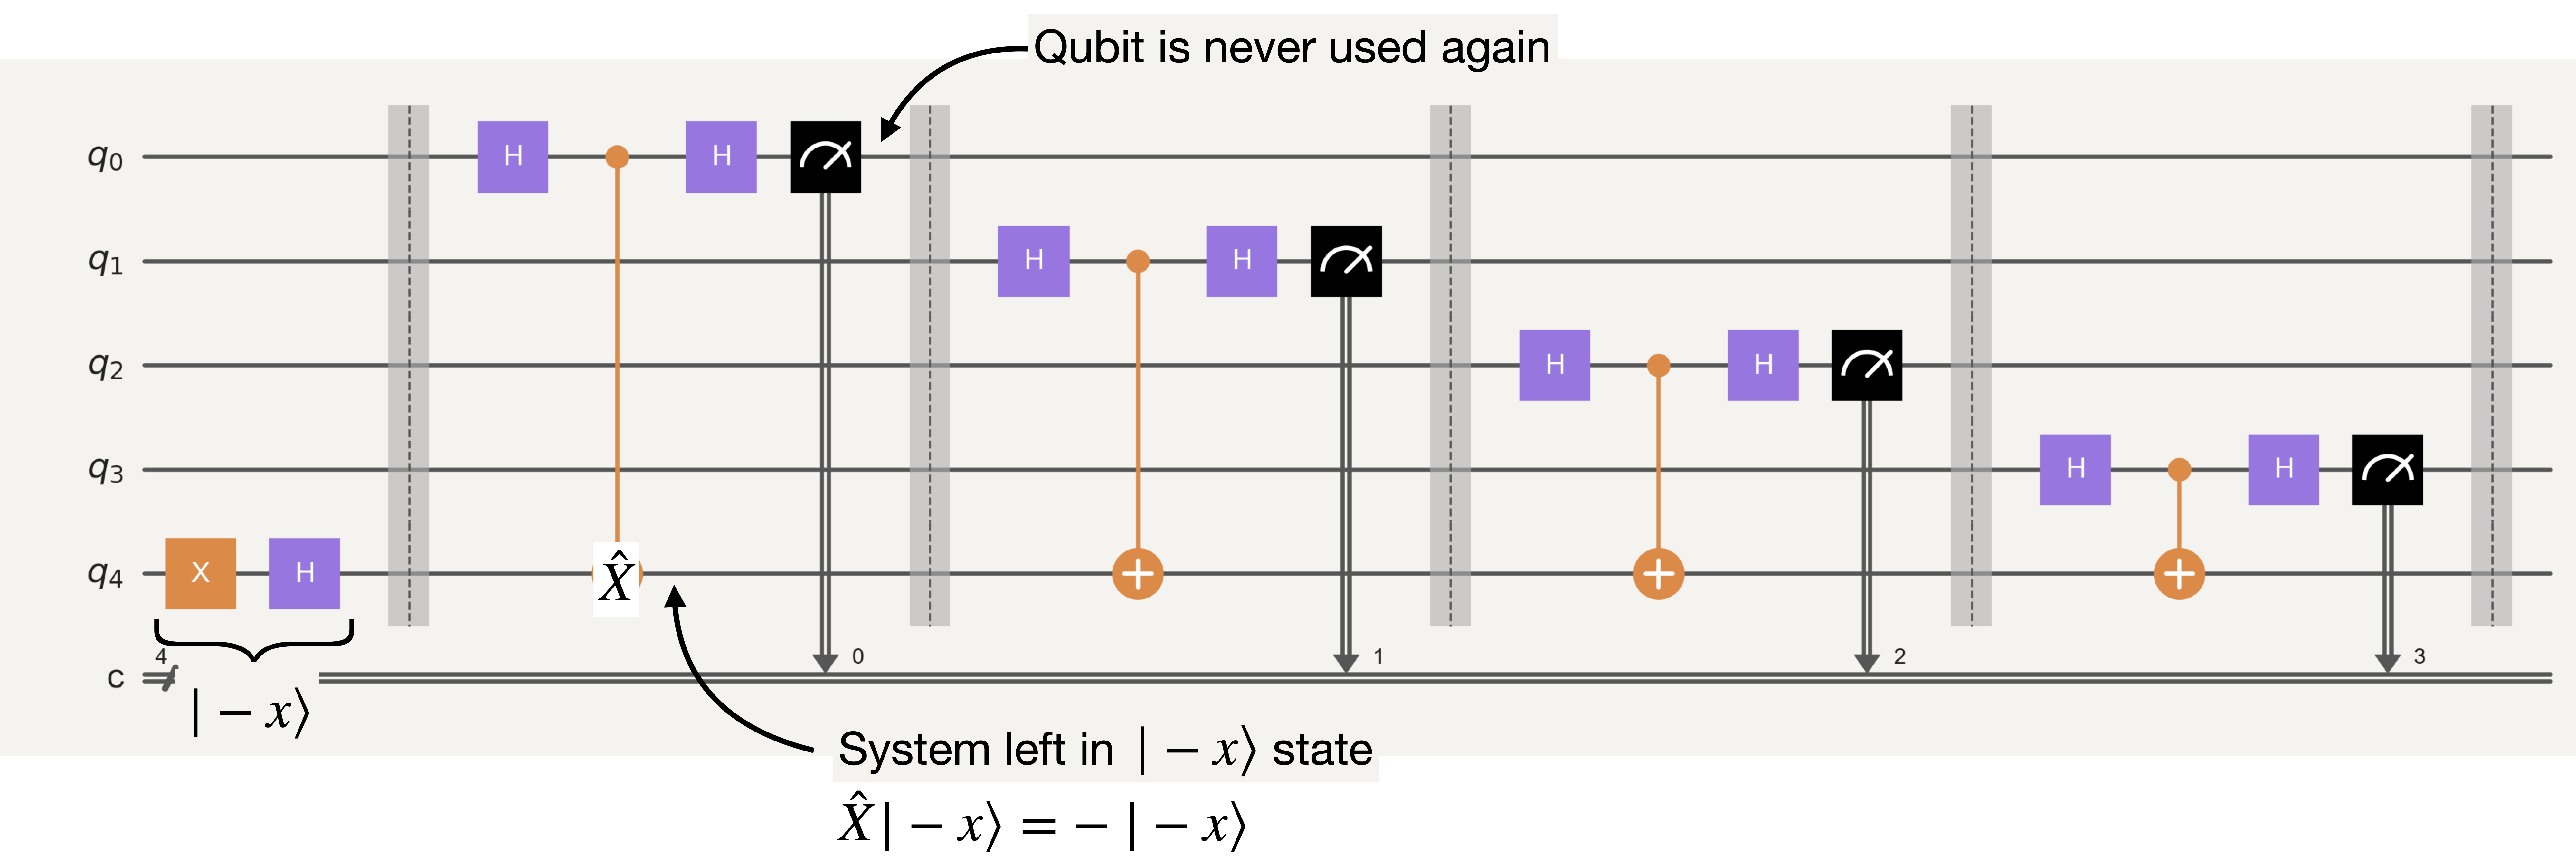

위의 그림에서 볼 수 있듯이, BV회로는 회로를 dynamic circuit을 사용해 fidelity를 끌어올리기에 좋은 구조로 되어있습니다.
각 큐비트는 phase kickback에 auxilary 큐비트와 대상 큐비트, 두개씩만 사용되며 이 큐비트 들은 다시 재사용 되지 않습니다. 따라서 dynamic 회로를 사용하면 회로의 크기와 depth를 극적으로 향상시킬수있습니다.

In [51]:
def dynamic_bv(bitstring):
    """Create a Bernstein-Vazirani circuit from a given bitstring.
    
    Parameters:
        bitstring (str): A bitstring.
        
    Returns:
        QuantumCircuit: Output circuit.
    """
    qc = QuantumCircuit(2, len(bitstring))
    
    # Prepare the |-x> state on target qubit
    qc.x(1)
    qc.h(1)
    
    # For each bit (0 or 1) build a simple circuit block
    for idx, bit in enumerate(bitstring[::-1]):
        
        # Initial H gate on control
        qc.h(0)
        # If bit=1, do a CNOT gate
        if int(bit):
            qc.cx(0, 1)
        # Final H gate to convert phase to computational-basis
        qc.h(0)
        # Measure
        qc.measure(0,idx)
        
        # If not at the final bit, recycle and reset qubits
        if idx != (len(bitstring)-1):
            qc.barrier([0,1])
            # Reset control qubit for reuse
            qc.reset(0)
            # reset target qubit to minimize dephasing
            qc.reset(1)
            # Prepare the |-x> state on target qubit again
            qc.x(1)
            qc.h(1)

    return qc


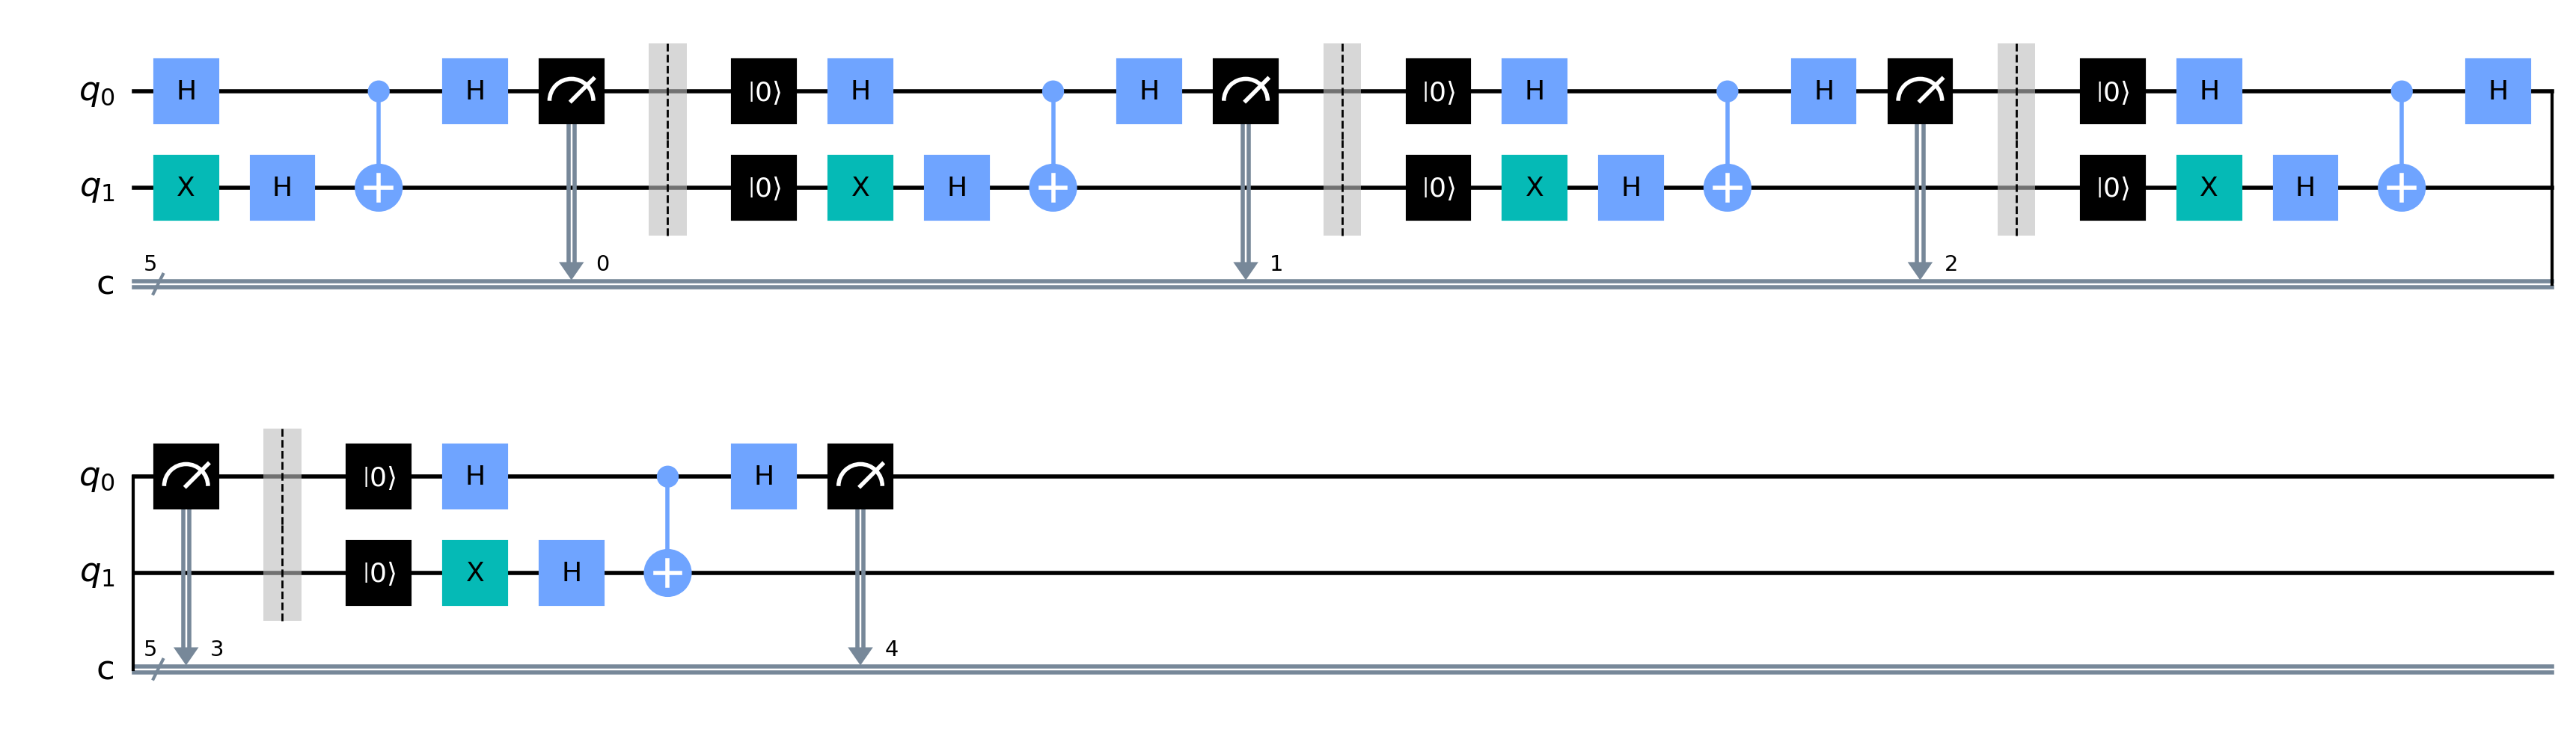

In [52]:
dyn_qc = dynamic_bv('1'*5)
dyn_qc.draw('mpl')

In [53]:
dyn_bv_circs = [dynamic_bv('1'*N) for N in range(2, MAX_BITS+1)]

In [54]:
trans_dyn_circs = transpile(dyn_bv_circs, backend=backend, optimization_level=3, scheduling_method='alap')
#dyn_job = backend.run(trans_dyn_circs, shots=10000, dynamic=True)
#dyn_job.job_id()

In [55]:
dyn_job = prov.retrieve_job('ch3e6v8l1tcjfhlen3m0')

dyn_counts = dyn_job.result().get_counts()
dyn_fidelities = [hellinger_fidelity(cnts, {'1'*(idx+2): 1}) for idx, cnts in enumerate(dyn_counts)]


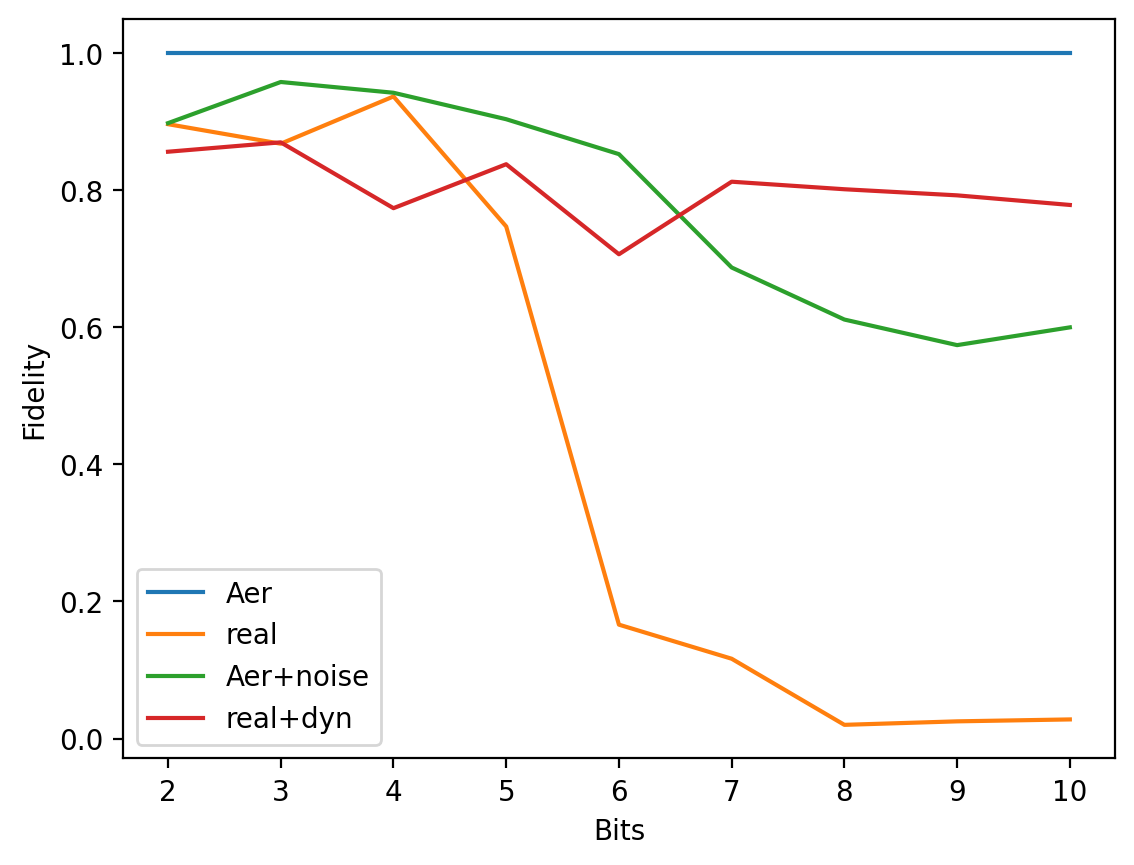

In [56]:
fig, ax = plt.subplots()
ax.plot(range(2, MAX_BITS+1), Aer_fidelities, label='Aer')
ax.plot(range(2, MAX_BITS+1), real_fidelities, label='real')
ax.plot(range(2, MAX_BITS+1), sim_fidelities, label='Aer+noise')
ax.plot(range(2, MAX_BITS+1), dyn_fidelities, label='real+dyn')
ax.set_xlabel('Bits')
ax.set_ylabel('Fidelity')
ax.legend();

오늘부터 일주일 동안 Qiskit Developer Certificate 자격증 문제를 기반으로 한 퀴즈 플랫폼을 열어두겠습니다 :)

https://ahaslides.com/LJUNU

일주일 후 상위 5인에게 특별 선물을 드립니다!